# SRCCA and Boolean Analysis of Phillips 2018 hPSC Retina Dataset

We will attempt to improve the prediction accuracy of marker genes of retinal cell types by using boolean implication analysis.

## Index

#### Reproduction
<br>[Reproduction of Top 200 SRCCA genes in Fig. 7 of Phillips et al. 2018](#top-200)</br>

#### Rod Photoreceptors
<br>[Analysis of Rod PR genes - Fig. 7A from Phillips et al. 2018](#Analysis-of-Rod-PR-genes---Fig.-7A-from-Phillips-et-al.-2018) </br>
<br>[SRCCA Reproduction](#rod-srcca)</br>
<br>[Boolean Analysis](#rod-boolean)</br>
<br>[Evaluating the performance of boolean analysis](#rod-eval)</br>

#### Retinal Progenitor Cells
<br>[Analysis of Retinal Progenitor Cells (RPCs) - Fig. 7C from Phillips et al. 2018](#rpc)</br>
<br>[Reproducing results from SRCCA](#rpc-srcca)</br>
<br>[Finding gold standard genes for RPCs](#rpc-gs)</br>
<br>[Boolean Analysis](#rpc-boolean)</br>
<br>[Evaluation](#rpc-eval)</br>

#### Cone Photoreceptors
<br>[Analysis of Cone PRs - Fig. 6 from Phillips et al. 2018](#cone)</br>
<br>[Reproducing the results from SRCCA](#cone-srcca)</br>
<br>[Boolean Analysis](#cone-boolean)</br>
<br>[Evaluating the performance of ARR3 and GNAT2 as bait genes](#cone-eval1)</br>
<br>[Test whether boolean analysis leads to more retina-specific genes](#cone-eval2)</br>

#### Retinal Ganglion Cells
<br>[Analysis of Retinal Ganglion Cells - Fig. 7B from Phillips et al. 2018](#rgc)</br>
<br>[Finding Gold Standard Genes for RGCs](#rgc)</br>
<br>[Finding Bait Genes for RGCs](#rgc-bg)</br>
<br>[Evaluation](#rgc-eval)</br>

#### Retinal Pigment Epithelium
<br>[Analysis of Retinal Pigment Epithelium - Fig. 7B from Phillips et al. 2018](#rpe)</br>
<br>[Finding Bait Genes for RPE](#rpe)</br>
<br>[Boolean Analysis](#rpe-boolean)</br>
<br>[Evaluation](#rpe-eval)</br>

<br>[Some important functions](#func)</br>
<br>[Graphs](#graphs)</br>

### Test

In [1]:
import sys
sys.path.append("/Users/rohan/public_html/Hegemon")
%load_ext autoreload
%autoreload 2
import StepMiner as smn
import HegemonUtil as hu
import re
import numpy as np
import scipy
import math
import itertools
from itertools import combinations 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import statsmodels.stats.proportion


In [2]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT29"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()
title = h.getTitle()
headers = h.getHeaders(1)
print(headers)
atype = h.getSurvName("c cell source")
hu.uniq(atype)
#atype

None


[6, 'c cell source', '']

In [5]:
t = h.getThrData("MKL2")
t

[1.9572762560115105, 854.5815080167131, 1.4572762560115105, 2.4572762560115105]

In [14]:
info= "/Users/rohan/public_html/Hegemon/Data2/Data/phillips-2018-retina-info.txt"
key= "rt:"
source= "GSE98556"
e = h.getExprData("PDE6B")
e
#e

/booleanfs2/sahoo/Data/RB/Human/GSE98556/phillips-2018-retina-expr.txt


['PDE6B',
 'PDE6B: NM_000283.1,NM_001145291.1,NM_001145292.1',
 '8.68558980116994',
 '9.54812832358559',
 '2.99276843076892',
 '10.4481679399558',
 '11.4300918328136',
 '9.04930403348226',
 '9.79986441088185',
 '',
 '10.5848967514021',
 '4.18665901720211',
 '10.6908099138348',
 '11.4877646821839',
 '6.74160181141324',
 '0.863938450423971',
 '8.19652836093694',
 '12.193297418855',
 '',
 '6.28429202639431',
 '13.8292708312549',
 '11.3036437769561',
 '11.9407210183641',
 '7.52057939628989',
 '4.10852445677817',
 '11.589665189552',
 '6.5703111243188',
 '3.49185309632968',
 '3.89917563048051',
 '10.850640050917',
 '10.7530579269622',
 '10.4318631938951',
 '10.4290091347959',
 '2.89141918684608',
 '10.865253839149',
 '9.99829424493687',
 '10.1343236336455',
 '10.2875277027646',
 '3.32048467801769',
 '7.11207455130968',
 '6.29296575471766',
 '7.67178871842323',
 '11.4127815253385',
 '7.52489426544877',
 '10.5945018970783',
 '9.77970294213718',
 '6.53962412155905',
 '10.9642831010687',
 '9.913

In [13]:
v1 = [math.nan if e[i] == "" else float(e[i]) for i in h.aRange()]
type(v1)

list

# SRCCA Analysis (Spearman's Rank Correlation Coefficent)

Some functions to identify top correlating genes:

In [727]:
import scipy
def getCorr2(db, dbid, e1, gene2, cellSource, h):
    
    e2 = h.getExprData(gene2)
    v1 = [float(e1[i]) for i in h.aRange()]
    v2 = [float(e2[i]) for i in h.aRange()]
    
    if cellSource != "All":
        atype = h.getSurvName("c Cell source")
        atype_c = [] # list of required positions with correct characteristic
        for i in range(len(atype)):
            if atype[i] == cellSource:
                atype_c.append(i-2) #index 2 onwards are values
        cv1 = [v1[i] for i in atype_c]
        cv2 = [v2[i] for i in atype_c]
        corr = scipy.stats.spearmanr(cv1,cv2,nan_policy='omit')
    else:
        corr = scipy.stats.spearmanr(v1,v2,nan_policy='omit')
    return corr

In [27]:
import scipy
import HegemonUtil as hu
import numpy as np
np.seterr(all='ignore')

def getCorrs(db, dbid, gene, cellSource):
    h = hu.Hegemon(db.getDataset(dbid))
    h.init()
    h.initPlatform()
    h.initSurv()
    
    corrdict = {}
    e1 =  h.getExprData(gene)
    for i in h.getAllIDs():
        name = h.getName(i)
        sr = getCorr2(db, dbid, e1, name, cellSource, h)
        if name not in corrdict:
            corrdict[name] = sr
        if abs(sr.correlation) > abs(corrdict[name].correlation):
            corrdict[name] = sr
    return corrdict

db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "B2"
#CRX_corr = getCorrs(db, dbid, "CRX", "All")
#print(CRX_corr)
PMEL_corr = getCorrs(db, dbid, "PMEL", "D070")
TYRP1_corr = getCorrs(db, dbid, "TYRP1", "D070")
#print(PMEL_corr)
        

In [50]:
import math
def sortCorr(Gene_corr):
    sorted_Gene = sorted(list(Gene_corr.items()), 
                         key=lambda x: -1 if math.isnan((x[1].correlation)) 
                         else x[1].correlation, reverse = True)    
    return(sorted_Gene)

In [29]:
def Top200Corrs(db, dbid, gene, cellSource):
    h = hu.Hegemon(db.getDataset(dbid))
    h.init()
    h.initPlatform()
    h.initSurv()
    
    corrdict = {}
    e1 =  h.getExprData(gene)
    for i in h.getAllIDs():
        name = h.getName(i)
        sr = getCorr2(db, dbid, e1, name, cellSource, h)
        if name not in corrdict:
            corrdict[name] = sr
        if abs(sr.correlation) > abs(corrdict[name].correlation):
            corrdict[name] = sr
    corrdict = sortCorr(corrdict)
    return corrdict[0:200]

db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "B2"
#PMEL_200 = Top200Corrs(db, dbid, "PMEL", "D070")
#TYRP1_200 = Top200Corrs(db, dbid, "TYRP1", "D070")

In [728]:
#NRL and NR2F3 - Fig. 7A Rod PRs
def getAllCorrs(db, dbid, gene, cellSource):
    h = hu.Hegemon(db.getDataset(dbid))
    h.init()
    h.initPlatform()
    h.initSurv()
    
    corrdict = {}
    e1 =  h.getExprData(gene)
    for i in h.getAllIDs():
        name = h.getName(i)
        sr = getCorr2(db, dbid, e1, name, cellSource, h)
        if name not in corrdict:
            corrdict[name] = sr
        if abs(sr.correlation) > abs(corrdict[name].correlation):
            corrdict[name] = sr
    return corrdict

db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "B2"
NRL_all = getAllCorrs(db, dbid, "NRL", "Adult")
NR2E3_all = getAllCorrs(db, dbid, "NR2E3", "Adult")

## Analysis of Rod PR genes - Fig. 7A from Phillips et al. 2018 

<a id="rod-srcca"></a>

### SRCCA Reproduction

In [730]:
#Accuracy of reproduction in prev. cell
phillips_NRL_NR2E3 = ['ABCA4', 'CNGA1', 'FOXJ1', 'MAK', 'PFKFB2', 'RGS9', 'TTC39C', 'ABCA7',
                      'CNGB1', 'GDF10', 'MSI1', 'PIAS4', 'RHO', 'UBXN11', 'AHI1', 'CNTRL', 
                      'GNAT1', 'MTA2', 'PLEKHB1', 'ROM1', 'UCKL1', 'AIPL1', 'CROCC', 'GNGT1', 
                      'NME7', 'PODXL', 'RP1', 'ANKRD53', 'DEFB119', 'GRK1', 'NOL6', 'PPEF2', 
                      'RTBDN', 'CACNA2D4', 'ELOVL4', 'IMPG2', 'NR2E3', 'PTP4A3', 'SAG', 'CASZ1',
                      'EVL', 'IQGAP2', 'NRL', 'PTPN13', 'SPTBN5', 'CDHR1', 'F13A1', 'JMJD1C', 
                      'PDE6B', 'RBP3', 'SYCE1L', 'CDR2', 'FAM57B', 'LSR', 'PDE6G', 'RDH12',
                      'SYVN1']

NRL_thr = [k for k in NRL_all if NRL_all[k].correlation > 0.20]
NR2E3_thr = [k for k in NR2E3_all if NR2E3_all[k].correlation > 0.21]

NRL_NR2E3 = set(NRL_thr).intersection(NR2E3_thr)
set(phillips_NRL_NR2E3).difference(NRL_NR2E3)


set()

<a id="rod-boolean"></a>

### Boolean Analysis

In [60]:
import re
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT29"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()
res1 = h.getBooleanRelations("PDE6B")
res2 = h.getBooleanRelations("NR2E3")

l1 = [hu.getBooleanRelationType(i[2], 2.5, 0.25) for i in res1]
l2 = [hu.getBooleanRelationType(i[2], 2.5, 0.25) for i in res2]
l3 = [i[0] for i in l1]
l4 = [i[0] for i in l2]
print (dict((x,l3.count(x)) for x in set(l3)))
print (dict((x,l4.count(x)) for x in set(l4)))
res3 = [res1[i][1] for i in range(len(res1)) \
        if (l3[i] == 2 or l3[i] == 5) and \
        (l4[i] == 3 or l4[i] == 5)]
#print " ".join(res3)
idstr = '''ABCA4	CNGA1	FOXJ1	MAK	PFKFB2	RGS9	TTC39C
ABCA7	CNGB1	GDF10	MSI1	PfAS4	RHO	UBXN11
AHI1	CNTRL	GNAT1	MTA2	PLEKHBl	ROM1	UCKL1
AIPL1	CROCC	GNGT1	NME7	PODXL	RPl	
ANKRD53	DEFB119	GRK1	NOL6	PPEF2	RTBDN	
CACNA2D4	ELOVL4	IMPG2	NR2E3	PTP4A3	SAG	
CASZ1	EVL	IQGAP2	NRL	PTPN13	SPTBNS	
CDHR1	F13A1	JMJDlC	PDE6B	RBP3	SYCE1L	
CDR2	FAM57B	LSR	PDE6G	RDH12	SYVN1	
'''
idstr1 = '''	NRL	NR2E3		
				
CNGA1				RGS9
CNGB1				RHO
	GNAT1			ROM1
	GNGT1			
	GRK1			
		NR2E3		SAG
		NRL		
		PDE6B		
		PDE6G		
'''
ids = re.split("\s", idstr)
ids1 = re.split("\s", idstr1)
res4 = list(set(ids) & set(res3))
print (" ".join(sorted(res4)))
print("--")
res5 = list(set(ids).difference(set(res3)))

print (" ".join(sorted(res5)))
len(res3)
 


{0: 17228, 1: 34, 2: 338, 3: 1167, 4: 323, 5: 8}
{0: 17119, 2: 27, 3: 1304, 4: 643, 5: 5}
ABCA4 AIPL1 CASZ1 CNGA1 CNGB1 DEFB119 GNAT1 GNGT1 NR2E3 NRL PDE6B PDE6G PODXL PPEF2 RBP3 RGS9 RHO ROM1 SAG TTC39C
--
 ABCA7 AHI1 ANKRD53 CACNA2D4 CDHR1 CDR2 CNTRL CROCC ELOVL4 EVL F13A1 FAM57B FOXJ1 GDF10 GRK1 IMPG2 IQGAP2 JMJDlC LSR MAK MSI1 MTA2 NME7 NOL6 PFKFB2 PLEKHBl PTP4A3 PTPN13 PfAS4 RDH12 RPl RTBDN SPTBNS SYCE1L SYVN1 UBXN11 UCKL1


43

In [4]:
import re
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT29"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()
res1 = h.getBooleanRelations("PDE6B")
res2 = h.getBooleanRelations("NR2E3")

l1 = [hu.getBooleanRelationType(i[2], 2.5, 0.25) for i in res1]
l2 = [hu.getBooleanRelationType(i[2], 2.5, 0.25) for i in res2]
l3 = [i[0] for i in l1]
l4 = [i[0] for i in l2]
print (dict((x,l3.count(x)) for x in set(l3)))
print (dict((x,l4.count(x)) for x in set(l4)))
res3 = [res1[i][1] for i in range(len(res1)) \
        if (l3[i] == 2 or l3[i] == 5) and \
        (l4[i] == 3 or l4[i] == 5)]

#Genes from SRCCA (Phillips et al 2017)
idstr = '''ABCA4	CNGA1	FOXJ1	MAK	PFKFB2	RGS9	TTC39C
ABCA7	CNGB1	GDF10	MSI1	PfAS4	RHO	UBXN11
AHI1	CNTRL	GNAT1	MTA2	PLEKHBl	ROM1	UCKL1
AIPL1	CROCC	GNGT1	NME7	PODXL	RPl	
ANKRD53	DEFB119	GRK1	NOL6	PPEF2	RTBDN	
CACNA2D4	ELOVL4	IMPG2	NR2E3	PTP4A3	SAG	
CASZ1	EVL	IQGAP2	NRL	PTPN13	SPTBNS	
CDHR1	F13A1	JMJDlC	PDE6B	RBP3	SYCE1L	
CDR2	FAM57B	LSR	PDE6G	RDH12	SYVN1	
'''

#Gold standard rod PR genes
idstr1 = '''	NRL	NR2E3		
				
CNGA1				RGS9
CNGB1				RHO
	GNAT1			ROM1
	GNGT1			
	GRK1			
		NR2E3		SAG
		NRL		
		PDE6B		
		PDE6G		
'''

ids = re.split("\s", idstr)
ids1 = re.split("\s", idstr1)

print("Genes from Boolean Analysis")
print (" ".join(sorted(res3)))
print("--")

#Intersection of SRCCA and Boolean Analysis
res4 = list(set(ids) & set(res3))
print("Intersection with SRCCA")
print (" ".join(sorted(res4)))

{0: 17228, 1: 34, 2: 338, 3: 1167, 4: 323, 5: 8}
{0: 17119, 2: 27, 3: 1304, 4: 643, 5: 5}
Genes from Boolean Analysis
ABCA4 AIPL1 BCO2 CABP5 CASZ1 CLUL1 CNGA1 CNGB1 COBLL1 DDC DEFB119 GNAT1 GNGT1 GPX3 GUCA1A IMPG1 LGALSL MCF2L2 MPP4 NR2E3 NRL PDC PDE6A PDE6B PDE6G PODXL PPEF2 PRPH2 RASSF2 RBP3 RGS9 RHO ROM1 RP1 SAG SAMD7 SEPT4 SLC6A6 STEAP2 TRPM6 TTC39C USH2A USP2
--
Intersection with SRCCA
ABCA4 AIPL1 CASZ1 CNGA1 CNGB1 DEFB119 GNAT1 GNGT1 NR2E3 NRL PDE6B PDE6G PODXL PPEF2 RBP3 RGS9 RHO ROM1 SAG TTC39C


In [61]:
print(sorted(res3))
print(sorted(res4))

['ABCA4', 'AIPL1', 'BCO2', 'CABP5', 'CASZ1', 'CLUL1', 'CNGA1', 'CNGB1', 'COBLL1', 'DDC', 'DEFB119', 'GNAT1', 'GNGT1', 'GPX3', 'GUCA1A', 'IMPG1', 'LGALSL', 'MCF2L2', 'MPP4', 'NR2E3', 'NRL', 'PDC', 'PDE6A', 'PDE6B', 'PDE6G', 'PODXL', 'PPEF2', 'PRPH2', 'RASSF2', 'RBP3', 'RGS9', 'RHO', 'ROM1', 'RP1', 'SAG', 'SAMD7', 'SEPT4', 'SLC6A6', 'STEAP2', 'TRPM6', 'TTC39C', 'USH2A', 'USP2']
['ABCA4', 'AIPL1', 'CASZ1', 'CNGA1', 'CNGB1', 'DEFB119', 'GNAT1', 'GNGT1', 'NR2E3', 'NRL', 'PDE6B', 'PDE6G', 'PODXL', 'PPEF2', 'RBP3', 'RGS9', 'RHO', 'ROM1', 'SAG', 'TTC39C']


In [64]:
sorted(set(res3).difference(ids1))

['ABCA4',
 'AIPL1',
 'BCO2',
 'CABP5',
 'CASZ1',
 'CLUL1',
 'COBLL1',
 'DDC',
 'DEFB119',
 'GPX3',
 'GUCA1A',
 'IMPG1',
 'LGALSL',
 'MCF2L2',
 'MPP4',
 'PDC',
 'PDE6A',
 'PODXL',
 'PPEF2',
 'PRPH2',
 'RASSF2',
 'RBP3',
 'RP1',
 'SAMD7',
 'SEPT4',
 'SLC6A6',
 'STEAP2',
 'TRPM6',
 'TTC39C',
 'USH2A',
 'USP2']

In [213]:
import re
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT29"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

atype = h.getSurvName("c cell source")
d70 = np.array([i for i in h.aRange() if atype[i] == "D070"])
mature = np.array([i for i in h.aRange() if atype[i] == "D218" or atype[i] == "Adult"])

res1 = getBooleanRels2("PDE6B", "NR2E3", arr=mature)
print(res1)

ids = re.split("\s", idstr)
ids1 = re.split("\s", idstr1)
res2 = list(set(ids) & set(res1))
print (sorted(res2))
print("--")
res3 = list(set(ids).difference(set(res1)))

print (sorted(res3))

{0: 18704, 1: 144, 2: 119, 3: 11, 4: 107, 5: 9, 6: 4}
{0: 18094, 1: 3, 2: 31, 3: 57, 4: 895, 5: 16, 6: 2}
['SLC23A2', 'GLB1L2', 'MPP4', 'RDH12', 'USP2', 'MTA2', 'PDE6G', 'HSPA1A', 'SLC24A1', 'CLUL1', 'F13A1', 'CNGA1', 'PTP4A3', 'PRPH2', 'DEFB119', 'PPEF2', 'CASZ1', 'CNGB1', 'DNAJB1', 'NR2E3', 'RASSF2', 'PRCD', 'SAMD7', 'AIPL1', 'PDE6B', 'FUT3', 'RP1', 'SAG', 'RBP3', 'ROM1', 'RHO', 'DDC', 'RGS9', 'GNAT1', 'HSPA1B', 'CABP5', 'GNGT1', 'RTBDN', 'ABCA4', 'PDE6A', 'PADI2', 'PDC', 'TF', 'GUCA1A', 'BCO2', 'NRL', 'NTM', 'PODXL']
['ABCA4', 'AIPL1', 'CASZ1', 'CNGA1', 'CNGB1', 'DEFB119', 'F13A1', 'GNAT1', 'GNGT1', 'MTA2', 'NR2E3', 'NRL', 'PDE6B', 'PDE6G', 'PODXL', 'PPEF2', 'PTP4A3', 'RBP3', 'RDH12', 'RGS9', 'RHO', 'ROM1', 'RTBDN', 'SAG']
--
['', 'ABCA7', 'AHI1', 'ANKRD53', 'CACNA2D4', 'CDHR1', 'CDR2', 'CNTRL', 'CROCC', 'ELOVL4', 'EVL', 'FAM57B', 'FOXJ1', 'GDF10', 'GRK1', 'IMPG2', 'IQGAP2', 'JMJDlC', 'LSR', 'MAK', 'MSI1', 'NME7', 'NOL6', 'PFKFB2', 'PLEKHBl', 'PTPN13', 'PfAS4', 'RPl', 'SPTBNS', 'SYC

In [192]:
print(res4)
print(res5)

['RBP3', 'DEFB119', 'RHO', 'CASZ1', 'PODXL', 'ABCA4', 'NR2E3', 'ROM1', 'SAG', 'ELOVL4', 'PPEF2', 'RGS9', 'GNGT1', 'F13A1', 'IMPG2', 'CDHR1', 'CNGA1', 'PTPN13', 'PTP4A3', 'RTBDN', 'CNGB1', 'TTC39C', 'MAK', 'GNAT1', 'RDH12', 'PFKFB2', 'AIPL1', 'UCKL1', 'PDE6G', 'PDE6B', 'NRL', 'MTA2']
['', 'PfAS4', 'CROCC', 'PLEKHBl', 'MSI1', 'ANKRD53', 'SYVN1', 'JMJDlC', 'AHI1', 'NOL6', 'CACNA2D4', 'FOXJ1', 'CNTRL', 'GDF10', 'ABCA7', 'FAM57B', 'LSR', 'EVL', 'SYCE1L', 'GRK1', 'UBXN11', 'RPl', 'IQGAP2', 'SPTBNS', 'CDR2', 'NME7']


### Test all possible pairs of bait genes from gold standard

In [94]:
# all possible bait genes

import re
import itertools
from itertools import combinations 
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT29"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

idstr = '''ABCA4	CNGA1	FOXJ1	MAK	PFKFB2	RGS9	TTC39C
ABCA7	CNGB1	GDF10	MSI1	PfAS4	RHO	UBXN11
AHI1	CNTRL	GNAT1	MTA2	PLEKHBl	ROM1	UCKL1
AIPL1	CROCC	GNGT1	NME7	PODXL	RPl	
ANKRD53	DEFB119	GRK1	NOL6	PPEF2	RTBDN	
CACNA2D4	ELOVL4	IMPG2	NR2E3	PTP4A3	SAG	
CASZ1	EVL	IQGAP2	NRL	PTPN13	SPTBNS	
CDHR1	F13A1	JMJDlC	PDE6B	RBP3	SYCE1L	
CDR2	FAM57B	LSR	PDE6G	RDH12	SYVN1	
'''
idstr1 = '''	NRL	NR2E3		
				
CNGA1				RGS9
CNGB1				RHO
	GNAT1			ROM1
	GNGT1			
	GRK1			
		NR2E3		SAG
		NRL		
		PDE6B		
		PDE6G		
'''
bait_dict = {}

idstr2 = re.split("\s", idstr1)
idstr2 = [i for i in idstr2 if i != '']
bait_list = itertools.combinations(idstr2, 2)
for a in bait_list:
    res1 = h.getBooleanRelations(a[1])
    res2 = h.getBooleanRelations(a[0])
    l1 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res1]
    l2 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res2]
    l3 = [i[0] for i in l1]
    l4 = [i[0] for i in l2]
    res3 = [res1[i][1] for i in range(len(res1)) \
            if (l3[i] == 2 or l3[i] == 5) and \
            (l4[i] == 3 or l4[i] == 5)]
    
    res3 = set(ids) & set(res3)
    res4 = list(set(idstr2).difference(set(res3))) # no. of starred genes omitted 
    bait_dict[a] = len(res4)
print(bait_dict)

{('NRL', 'NR2E3'): 3, ('NRL', 'CNGA1'): 2, ('NRL', 'RGS9'): 2, ('NRL', 'CNGB1'): 2, ('NRL', 'RHO'): 2, ('NRL', 'GNAT1'): 1, ('NRL', 'ROM1'): 2, ('NRL', 'GNGT1'): 1, ('NRL', 'GRK1'): 13, ('NRL', 'SAG'): 1, ('NRL', 'NRL'): 2, ('NRL', 'PDE6B'): 1, ('NRL', 'PDE6G'): 1, ('NR2E3', 'CNGA1'): 2, ('NR2E3', 'RGS9'): 2, ('NR2E3', 'CNGB1'): 2, ('NR2E3', 'RHO'): 2, ('NR2E3', 'GNAT1'): 1, ('NR2E3', 'ROM1'): 2, ('NR2E3', 'GNGT1'): 1, ('NR2E3', 'GRK1'): 13, ('NR2E3', 'NR2E3'): 3, ('NR2E3', 'SAG'): 1, ('NR2E3', 'NRL'): 2, ('NR2E3', 'PDE6B'): 1, ('NR2E3', 'PDE6G'): 1, ('CNGA1', 'RGS9'): 2, ('CNGA1', 'CNGB1'): 2, ('CNGA1', 'RHO'): 2, ('CNGA1', 'GNAT1'): 1, ('CNGA1', 'ROM1'): 2, ('CNGA1', 'GNGT1'): 1, ('CNGA1', 'GRK1'): 13, ('CNGA1', 'NR2E3'): 3, ('CNGA1', 'SAG'): 1, ('CNGA1', 'NRL'): 2, ('CNGA1', 'PDE6B'): 1, ('CNGA1', 'PDE6G'): 1, ('RGS9', 'CNGB1'): 2, ('RGS9', 'RHO'): 2, ('RGS9', 'GNAT1'): 1, ('RGS9', 'ROM1'): 2, ('RGS9', 'GNGT1'): 1, ('RGS9', 'GRK1'): 13, ('RGS9', 'NR2E3'): 3, ('RGS9', 'SAG'): 1, ('RG

<a id = 'rod-eval'></a>

### Evaluating the performance of boolean analysis

Boolean Intersection Correlation

In [239]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT14"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

atype = h.getSurvName("c tissue")
whole_eye = np.array([i for i in h.aRange() if atype[i] == "Whole Eye" or atype[i] == "eye"])
retina = np.array([i for i in h.aRange() if atype[i] == "Retina"])

rod_corr = np.array(['ABCA4', 'CNGA1', 'FOXJ1', 'MAK', 'PFKFB2', 'RGS9', 'TTC39C', 'ABCA7', 'CNGB1', 'GDF10', 'MSI1', 'PfAS4',
            'RHO', 'UBXN11', 'AHI1', 'CNTRL', 'GNAT1', 'MTA2', 'PLEKHBl', 'ROM1', 'UCKL1', 'AIPL1', 'CROCC', 'GNGT1',
            'NME7', 'PODXL', 'RPl', 'ANKRD53', 'DEFB119', 'GRK1', 'NOL6', 'PPEF2', 'RTBDN', 'CACNA2D4', 'ELOVL4',
            'IMPG2', 'NR2E3', 'PTP4A3', 'SAG', 'CASZ1', 'EVL', 'IQGAP2', 'NRL', 'PTPN13', 'SPTBN5', 'CDHR1', 'F13A1',
            'JMJDlC', 'PDE6B', 'RBP3', 'SYCE1L', 'CDR2', 'FAM57B', 'LSR', 'PDE6G', 'RDH12', 'SYVN1'])

rod_boolean = np.array(['ABCA4', 'AIPL1', 'CASZ1', 'CDHR1', 'CNGA1', 'CNGB1', 'DEFB119', 'ELOVL4', 'F13A1', 'GNAT1',
                        'GNGT1', 'IMPG2', 'MAK', 'MTA2', 'NR2E3', 'NRL', 'PDE6B', 'PDE6G', 'PFKFB2', 'PODXL', 'PPEF2',
                        'PTP4A3', 'PTPN13', 'RBP3', 'RDH12', 'RGS9', 'RHO', 'ROM1', 'RTBDN', 'SAG', 'TTC39C', 'UCKL1'])

removed = ['DEFB119']
#res4 = ['RBP3', 'DEFB119', 'RHO', 'CASZ1', 'PODXL', 'ABCA4', 'NR2E3', 'ROM1', 'SAG', 'ELOVL4', 'PPEF2', 'RGS9', 'GNGT1', 'F13A1', 'IMPG2', 'CDHR1', 'CNGA1', 'PTPN13', 'PTP4A3', 'RTBDN', 'CNGB1', 'TTC39C', 'MAK', 'GNAT1', 'RDH12', 'PFKFB2', 'AIPL1', 'UCKL1', 'PDE6G', 'PDE6B', 'NRL', 'MTA2']
res4 = ['ABCA4', 'AIPL1', 'CASZ1', 'CNGA1', 'CNGB1', 'DEFB119', 'F13A1', 'GNAT1', 'GNGT1', 'MTA2', 'NR2E3', 'NRL', 'PDE6B', 'PDE6G', 'PODXL', 'PPEF2', 'PTP4A3', 'RBP3', 'RDH12', 'RGS9', 'RHO', 'ROM1', 'RTBDN', 'SAG']
#rod_boolean_2 = sorted(set(rod_boolean).difference(removed))
rod_boolean_2 = sorted(set(res4).difference(removed))
boolean_dict = {}
for i in rod_boolean_2:
    expr = h.getExprData(i)
    expr_we = np.array([float(expr[x]) for x in whole_eye if expr[x] != ''])
    expr_re = np.array([float(expr[x]) for x in retina if expr[x] != ''])
    boolean_dict[i] = scipy.stats.ttest_ind(expr_we, expr_re, equal_var = False)
print(boolean_dict)
pass_dict = {i:boolean_dict[i].pvalue for i in list(boolean_dict.keys()) if boolean_dict[i].statistic<0 and \
            boolean_dict[i].pvalue/2 < 0.05}
fail_dict = {i:boolean_dict[i].pvalue for i in list(boolean_dict.keys()) if boolean_dict[i].statistic>0 and \
            boolean_dict[i].pvalue/2 < 0.05}
print(pass_dict)
print(len(rod_boolean_2))
print(len(pass_dict))
print("pass")
print(len(pass_dict)/len(rod_boolean_2))
print("fail")
print(len(fail_dict))
print(len(fail_dict)/len(rod_boolean_2))

{'ABCA4': Ttest_indResult(statistic=-8.215260180543345, pvalue=3.794021378292992e-08), 'AIPL1': Ttest_indResult(statistic=-10.07827958049902, pvalue=1.0359915615014217e-10), 'CASZ1': Ttest_indResult(statistic=-12.659241371974534, pvalue=1.8226970839760767e-12), 'CNGA1': Ttest_indResult(statistic=-2.752442298645998, pvalue=0.011989522811600746), 'CNGB1': Ttest_indResult(statistic=-5.399027612091046, pvalue=0.00020320683242803302), 'F13A1': Ttest_indResult(statistic=13.829116431119049, pvalue=8.692860693578587e-12), 'GNAT1': Ttest_indResult(statistic=-4.872473608443639, pvalue=7.916912276149278e-05), 'GNGT1': Ttest_indResult(statistic=-0.20771210067137788, pvalue=0.8373045882469481), 'MTA2': Ttest_indResult(statistic=-8.64890669172122, pvalue=2.5770905066020217e-09), 'NR2E3': Ttest_indResult(statistic=-5.292860433268478, pvalue=3.05643541681119e-05), 'NRL': Ttest_indResult(statistic=-5.346498829766813, pvalue=2.8175656612820966e-05), 'PDE6B': Ttest_indResult(statistic=-4.196124576936802,

Correlation and not boolean

In [240]:
removed = ['','JMJDlC','PLEKHBl','PfAS4', 'RPl', 'SPTBNS', 'CNTRL', 'DEFB119']
#rod_boolean_2 = sorted(set(rod_boolean).difference(removed))
#res5 =  ['', 'PfAS4', 'CROCC', 'PLEKHBl', 'MSI1', 'ANKRD53', 'SYVN1', 'JMJDlC', 'AHI1', 'NOL6', 'CACNA2D4', 'FOXJ1', 'CNTRL', 'GDF10', 'ABCA7', 'FAM57B', 'LSR', 'EVL', 'SYCE1L', 'GRK1', 'UBXN11', 'RPl', 'IQGAP2', 'SPTBNS', 'CDR2', 'NME7']
res5 = ['', 'ABCA7', 'AHI1', 'ANKRD53', 'CACNA2D4', 'CDHR1', 'CDR2', 'CNTRL', 'CROCC', 'ELOVL4', 'EVL', 'FAM57B', 'FOXJ1', 'GDF10', 'GRK1', 'IMPG2', 'IQGAP2', 'JMJDlC', 'LSR', 'MAK', 'MSI1', 'NME7', 'NOL6', 'PFKFB2', 'PLEKHBl', 'PTPN13', 'PfAS4', 'RPl', 'SPTBNS', 'SYCE1L', 'SYVN1', 'TTC39C', 'UBXN11', 'UCKL1']
rod_boolean_2 = sorted(set(res5).difference(removed))
boolean_dict = {}
print(rod_boolean_2)
for i in rod_boolean_2:
    print(i)
    expr = h.getExprData(i)
    expr_we = np.array([float(expr[x]) for x in whole_eye if expr[x] != ''])
    expr_re = np.array([float(expr[x]) for x in retina if expr[x] != ''])
    boolean_dict[i] = scipy.stats.ttest_ind(expr_we, expr_re, equal_var = False)
print(boolean_dict)
pass_dict = {i:boolean_dict[i].pvalue for i in list(boolean_dict.keys()) if boolean_dict[i].statistic<0 and \
            boolean_dict[i].pvalue/2 < 0.05}
fail_dict = {i:boolean_dict[i].pvalue for i in list(boolean_dict.keys()) if boolean_dict[i].statistic>0 and \
            boolean_dict[i].pvalue/2 < 0.05}
print(pass_dict)
print(len(rod_boolean_2))
print(len(pass_dict))
print("pass")
print(len(pass_dict)/len(rod_boolean_2))
print("fail")
print(len(fail_dict))
print(len(fail_dict)/len(rod_boolean_2))

['ABCA7', 'AHI1', 'ANKRD53', 'CACNA2D4', 'CDHR1', 'CDR2', 'CROCC', 'ELOVL4', 'EVL', 'FAM57B', 'FOXJ1', 'GDF10', 'GRK1', 'IMPG2', 'IQGAP2', 'LSR', 'MAK', 'MSI1', 'NME7', 'NOL6', 'PFKFB2', 'PTPN13', 'SYCE1L', 'SYVN1', 'TTC39C', 'UBXN11', 'UCKL1']
ABCA7
AHI1
ANKRD53
CACNA2D4
CDHR1
CDR2
CROCC
ELOVL4
EVL
FAM57B
FOXJ1
GDF10
GRK1
IMPG2
IQGAP2
LSR
MAK
MSI1
NME7
NOL6
PFKFB2
PTPN13
SYCE1L
SYVN1
TTC39C
UBXN11
UCKL1
{'ABCA7': Ttest_indResult(statistic=-9.82078369794348, pvalue=1.4382445181481048e-10), 'AHI1': Ttest_indResult(statistic=-10.57416878008828, pvalue=3.3527361399879853e-11), 'ANKRD53': Ttest_indResult(statistic=-2.6544969066450985, pvalue=0.028969460487519392), 'CACNA2D4': Ttest_indResult(statistic=-18.43940430189788, pvalue=2.0815864615840688e-15), 'CDHR1': Ttest_indResult(statistic=-5.860146494628641, pvalue=9.610982326429556e-05), 'CDR2': Ttest_indResult(statistic=-6.1844300624196675, pvalue=1.651690450135204e-06), 'CROCC': Ttest_indResult(statistic=-13.333934229471328, pvalue=5.7228

Correlation

In [190]:
removed = ['CNTRL','DEFB119','JMJDlC','PLEKHBl','PfAS4','RPl','SPTBN5']
rod_corr_2 = sorted(set(rod_corr).difference(removed))
corr_dict = {}
for i in rod_corr_2:
    expr = h.getExprData(i)
    expr_we = np.array([float(expr[x]) for x in whole_eye if expr[x] != ''])
    expr_re = np.array([float(expr[x]) for x in retina if expr[x] != ''])
    corr_dict[i] = scipy.stats.ttest_ind(expr_we, expr_re, equal_var = False)
print(corr_dict)
pass_dict = {i:corr_dict[i].pvalue for i in list(corr_dict.keys()) if corr_dict[i].statistic<0 and \
            corr_dict[i].pvalue/2 < 0.05}
print(pass_dict)
print(len(rod_corr_2))
len(pass_dict)/len(rod_corr_2)

{'ABCA4': Ttest_indResult(statistic=-8.215260180543345, pvalue=3.794021378292992e-08), 'ABCA7': Ttest_indResult(statistic=-9.82078369794348, pvalue=1.4382445181481048e-10), 'AHI1': Ttest_indResult(statistic=-10.57416878008828, pvalue=3.3527361399879853e-11), 'AIPL1': Ttest_indResult(statistic=-10.07827958049902, pvalue=1.0359915615014217e-10), 'ANKRD53': Ttest_indResult(statistic=-2.6544969066450985, pvalue=0.028969460487519392), 'CACNA2D4': Ttest_indResult(statistic=-18.43940430189788, pvalue=2.0815864615840688e-15), 'CASZ1': Ttest_indResult(statistic=-12.659241371974534, pvalue=1.8226970839760767e-12), 'CDHR1': Ttest_indResult(statistic=-5.860146494628641, pvalue=9.610982326429556e-05), 'CDR2': Ttest_indResult(statistic=-6.1844300624196675, pvalue=1.651690450135204e-06), 'CNGA1': Ttest_indResult(statistic=-2.752442298645998, pvalue=0.011989522811600746), 'CNGB1': Ttest_indResult(statistic=-5.399027612091046, pvalue=0.00020320683242803302), 'CROCC': Ttest_indResult(statistic=-13.33393

0.8

### Reproducing RGC Top 200 SRCCA genes 

In [179]:
#ATOH7 and POU4F2 - Fig. 7B RGCs
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "B2"
ATOH7_200 = Top200Corrs(db, dbid, "ATOH7", "D070")
POU4F2_200 = Top200Corrs(db, dbid, "POU4F2", "D070")
ATOH7_POU4F2 = overlap(ATOH7_200, POU4F2_200)
print(sorted(ATOH7_POU4F2))

['AFAP1', 'AKR1C1', 'ATOH7', 'BASP1', 'BCL7A', 'C6orf130', 'CDKN1C', 'CELF4', 'CHRNA3', 'CNTN2', 'DCX', 'EBF1', 'ELAVL2', 'ELAVL3', 'ELAVL4', 'FNDC5', 'ISL1', 'LCOR', 'NPTX2', 'OLFM2', 'PKIA', 'POU4F2', 'PPFIA2', 'PTPRD', 'RAB31', 'SLC17A8', 'SLC18A2', 'SNCG', 'SOX11', 'STMN2', 'TAGLN3', 'TUBB3']


In [12]:
#ATOH7 and POU4F2 - Fig. 7B RGCs
Phillips_ATOH7_POU4F2 = ['AFAP1', 'CHRNA3', 'LCOR', 'RAB31', 'ELAVL2', 'OLFM2', 'SNCG', 'AKR1C1', 'EBF1', 'OLIG2', 'TAGLN3', 'ELAVL3', 'POU4F2', 'SOX11', 'BCL7A', 'EPN2', 'PKIA', 'ATOH7', 'ELAVL4', 'PPP1R1A', 'STMN2', 'C6orf130', 'FHL1', 'PPFIA2', 'CELF4', 'ISL1', 'SLC17A8', 'TUBB3', 'CDKN1C', 'FNDC5', 'PTPRD', 'CNTN2', 'NPTX2', 'SLC1842']

db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "B2"
ATOH7_all = getAllCorrs(db, dbid, "ATOH7", "D070")
ATOH7_thr = [k for k in ATOH7_all if ATOH7_all[k].correlation > 0.23]

POU4F2_all = getAllCorrs(db, dbid, "POU4F2", "D070")
#POU4F2_thr = [k for k in POU4F2_all if POU4F2_all[k].correlation > ??]

ATOH7_POU4F2 = set(ATOH7_thr).intersection(POU4F2_all)
set(Phillips_ATOH7_POU4F2).difference(ATOH7_POU4F2)

{'EPN2', 'FHL1', 'PPP1R1A', 'SLC1842'}

In [180]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "B2"
VSX2_200 = Top200Corrs(db, dbid, "VSX2", "D070")
VIM_200 = Top200Corrs(db, dbid, "VIM", "D070")
VSX2_VIM = overlap(VSX2_200, VIM_200)
print(sorted(VSX2_VIM))

['ANXA5', 'ARL6IP6', 'ATP2B4', 'AURKB', 'B2M', 'CCDC34', 'CCNB2', 'CCND1', 'CDK1', 'CENPF', 'COL2A1', 'COL4A5', 'CPAMD8', 'CTDSP2', 'CYP1B1', 'DAPL1', 'DEPDC1B', 'DKK3', 'DLK1', 'DTX4', 'ECT2', 'EEF1D', 'EGFR', 'ELL2', 'FAT1', 'FBN1', 'FBN2', 'FEZF2', 'FGFR1', 'FKBP10', 'FOXN4', 'FZD5', 'GINS2', 'GLI3', 'GMNN', 'HAUS1', 'HAUS4', 'HES1', 'HES5', 'HMGB2', 'HMGN2', 'HTRA1', 'IFITM1', 'IFITM2', 'IFITM3', 'IGF2', 'ITM2C', 'KIAA0100', 'KIF22', 'KIF2C', 'KIF4A', 'MAD2L1', 'MCM6', 'MDK', 'MEST', 'METRN', 'MKI67', 'MYH9', 'NCAPG', 'NME4', 'NOTCH1', 'NOTCH2', 'NOTCH3', 'NR2E1', 'PABPC1', 'PABPC3', 'PCDH18', 'PDIA4', 'PHGDH', 'PLK1', 'PLS3', 'PRC1', 'PRSS23', 'PSME1', 'PTPRZ1', 'RPL11', 'RPL35', 'RPL41', 'RPL7', 'RPLP0', 'RPLP1', 'RPS10', 'RPS15A', 'RPS18', 'RPS19', 'RPS25', 'RPS27', 'RPS6', 'SARNP', 'SFRP2', 'SLC2A1', 'SMC4', 'SOX2', 'SPARC', 'STRA6', 'TACC3', 'TOP2A', 'TPX2', 'TTYH1', 'TUBA1B', 'TYMS', 'UBE2C', 'UHRF1', 'VCAN', 'VIM', 'VSX2', 'YAP1', 'ZFP36L1', 'ZFP36L2']


 <a id="top-200"></a>

## Fig. 7 - Top 200 SRCCA genes

#### Using the top 200 correlating genes did not yield a very high reproduction accuracy.
#### In the next section, we succesfully reproduce all of the genes by applying the thresholds applied in the paper, and move on to comparison with boolean analysis.

#### NRL and NR2F3 - Fig 7A Rod PR Genes 

Reproduction

['ABCA4', 'ABCA7', 'AFF1', 'AHI1', 'AIPL1', 'B4GALT1', 'CABP4', 'CACNA2D4', 'CAMSAP1', 'CASZ1', 'CDHR1', 'CNGB1', 'CNTRL', 'CROCC', 'CRX', 'DCX', 'DEFB119', 'DPYSL3', 'ELOVL4', 'EVL', 'F13A1', 'FAM57B', 'FTH1', 'GNAT1', 'GNAZ', 'GNGT1', 'GRK1', 'HNRNPH1', 'IMPG2', 'IQGAP2', 'JMJD1C', 'MAK', 'MPP4', 'MSI1', 'MTA2', 'NME7', 'NOL6', 'NR2E3', 'NRL', 'NTM', 'OSBP2', 'PDCD4', 'PDE6B', 'PDE6G', 'PFKFB2', 'PIAS4', 'PLEKHB1', 'PODXL', 'PPEF2', 'PRPH2', 'PTP4A3', 'PTPN13', 'RASSF2', 'RBP3', 'RDH12', 'RGS9', 'RHO', 'ROM1', 'RP1', 'RTBDN', 'SAG', 'SPTBN5', 'SYCE1L', 'TLCD2', 'TPP2', 'TRIP10', 'TTC39C', 'UBXN11', 'UCKL1', 'UNC119']

Phillips et al. 2018

['ABCA4', 'CNGA1', 'FOXJ1', 'MAK', 'PFKFB2', 'RGS9', 'TTC39C', 'ABCA7', 'CNGB1', 'GDF10', 'MSI1', 'PIAS4', 'RHO', 'UBXN11', 'AHI1', 'CNTRL', 'GNAT1', 'MTA2', 'PLEKHB1', 'ROM1', 'UCKL1', 'AIPL1', 'CROCC', 'GNGT1', 'NME7', 'PODXL', 'RP1', 'ANKRD53', 'DEFB119', 'GRK1', 'NOL6', 'PPEF2', 'RTBDN', 'CACNA2D4', 'ELOVL4', 'IMPG2', 'NR2E3', 'PTP4A3', 'SAG', 'CASZ1', 'EVL', 'IQGAP2', 'NRL', 'PTPN13', 'SPTBN5', 'CDHR1', 'F13A1', 'JMJD1C', 'PDE6B', 'RBP3', 'SYCE1L', 'CDR2', 'FAM57B', 'LSR', 'PDE6G', 'RDH12', 'SYVN1']

Accuracy: 87.7%


#### ATOH7 and POU4F2 - Fig. 7B RGC Genes

Reproduction

['AFAP1', 'AKR1C1', 'ATOH7', 'BASP1', 'BCL7A', 'C6orf130', 'CDKN1C', 'CELF4', 'CHRNA3', 'CNTN2', 'DCX', 'EBF1', 'ELAVL2', 'ELAVL3', 'ELAVL4', 'FNDC5', 'ISL1', 'LCOR', 'NPTX2', 'OLFM2', 'PKIA', 'POU4F2', 'PPFIA2', 'PTPRD', 'RAB31', 'SLC17A8', 'SLC18A2', 'SNCG', 'SOX11', 'STMN2', 'TAGLN3', 'TUBB3']

Phillips et al. 2018

['AFAP1', 'CHRNA3', 'LCOR', 'RAB31', 'ELAVL2', 'OLFM2', 'SNCG', 'AKR1C1', 'EBF1', 'OLIG2', 'TAGLN3', 'ELAVL3', 'POU4F2', 'SOX11', 'BCL7A', 'EPN2', 'PKIA', 'ATOH7', 'ELAVL4', 'PPP1R1A', 'STMN2', 'C6orf130', 'FHL1', 'PPFIA2', 'CELF4', 'ISL1', 'SLC17A8', 'TUBB3', 'CDKN1C', 'FNDC5', 'PTPRD', 'CNTN2', 'NPTX2', 'SLC1842']

Accuracy = 85.3%

#### VSX2 and VIM - Fig. 7C RPC Genes

Reproduction

['ANXA5', 'ARL6IP6', 'ATP2B4', 'AURKB', 'B2M', 'CCDC34', 'CCNB2', 'CCND1', 'CDK1', 'CENPF', 'COL2A1', 'COL4A5', 'CPAMD8', 'CTDSP2', 'CYP1B1', 'DAPL1', 'DEPDC1B', 'DKK3', 'DLK1', 'DTX4', 'ECT2', 'EEF1D', 'EGFR', 'ELL2', 'FAT1', 'FBN1', 'FBN2', 'FEZF2', 'FGFR1', 'FKBP10', 'FOXN4', 'FZD5', 'GINS2', 'GLI3', 'GMNN', 'HAUS1', 'HAUS4', 'HES1', 'HES5', 'HMGB2', 'HMGN2', 'HTRA1', 'IFITM1', 'IFITM2', 'IFITM3', 'IGF2', 'ITM2C', 'KIAA0100', 'KIF22', 'KIF2C', 'KIF4A', 'MAD2L1', 'MCM6', 'MDK', 'MEST', 'METRN', 'MKI67', 'MYH9', 'NCAPG', 'NME4', 'NOTCH1', 'NOTCH2', 'NOTCH3', 'NR2E1', 'PABPC1', 'PABPC3', 'PCDH18', 'PDIA4', 'PHGDH', 'PLK1', 'PLS3', 'PRC1', 'PRSS23', 'PSME1', 'PTPRZ1', 'RPL11', 'RPL35', 'RPL41', 'RPL7', 'RPLP0', 'RPLP1', 'RPS10', 'RPS15A', 'RPS18', 'RPS19', 'RPS25', 'RPS27', 'RPS6', 'SARNP', 'SFRP2', 'SLC2A1', 'SMC4', 'SOX2', 'SPARC', 'STRA6', 'TACC3', 'TOP2A', 'TPX2', 'TTYH1', 'TUBA1B', 'TYMS', 'UBE2C', 'UHRF1', 'VCAN', 'VIM', 'VSX2', 'YAP1', 'ZFP36L1', 'ZFP36L2']

Phillips et al. 2018

['ANXA5', 'DTX4', 'HES1', 'MEST', 'PTPRZ1', 'RPS17L', 'TLN1', 'ATP2B4', 'EEF1D', 'HESS', 'MK167', 'RPL11', 'RPS18', 'TOP2A', 'B2M', 'EGFR', 'HMGB2', 'MYH9', 'RPL14', 'RPS25', 'TPX2', 'CCDC34', 'ETV5', 'HMGN2', 'NCAPG', 'RPL23', 'RPS27', 'TTYH1', 'CCNB2', 'FAT1', 'HTRA1', 'NME4', 'RPL27', 'RPS27A', 'TUBA18', 'CCND1', 'FBN1', 'IFITM1', 'NOTCH1', 'RPL29', 'RPS5', 'TYMS', 'CDK1', 'FBN2', 'IFITM2', 'NOTCH2', 'RPL35', 'RPS6', 'U8E2C', 'CENPF', 'FEZF2', 'IFITM3', 'NOTCH3', 'RPL39', 'SARNP', 'VIM', 'CHAF1A', 'FGFR1', 'IGF2', 'PABPC1', 'RPL41', 'SFRP2', 'VSX2', 'COL2A1', 'FKBP10', 'ITM2C', 'PABPC3', 'RPL5', 'SLC2A1', 'YAP1', 'COL4A5', 'FOXN4', 'KIAA0100', 'PDIA4', 'RPL7', 'SMC4', 'ZFP36L1', 'CPAMD8', 'FZD5', 'KIF22', 'PHGDH', 'RPLPO', 'SNRPG', 'ZFP36L2', 'CTDSP2', 'GINS2', 'KIF4A', 'PLS3', 'RPLP2', 'SOX2', 'CYP181', 'GLI3', 'LGR4', 'PPP1CC', 'RPS10', 'SPARC', 'DAPL1', 'GMNN', 'MCM6', 'PRDX6', 'RPS15A', 'STAT1', 'DKK3', 'HAUS1', 'MDK', 'PRKDC', 'RPS17', 'STRA6'] 

Accuracy = 75.9%

#### PMEL and TYRP1 - Fig 7D RPE Genes

Reproduction

['AAMP', 'AEN', 'ALDH1A3', 'AMOTL2', 'ANXA11', 'ANXA2', 'APOE', 'ARF3', 'ARID5B', 'ARL5B', 'ATPAF2', 'BEST1', 'BFSP2', 'C11orf9', 'C17orf53', 'C1QTNF5', 'CA2', 'CCDC72', 'CDC25B', 'CDKN1A', 'CDR1', 'CDR2', 'CERS2', 'CFI', 'CHAF1A', 'CHCHD3', 'CHSY3', 'CLDN1', 'CNKSR3', 'CNTN1', 'CPAMD8', 'CRB2', 'CTDP1', 'CTSH', 'CYR61', 'DCHS1', 'DCT', 'DDRGK1', 'DHCR24', 'DHCR7', 'EEF2', 'EFEMP1', 'ELMO2', 'ELN', 'EMID2', 'ENPP2', 'EPAS1', 'FAT1', 'FAT4', 'FBN1', 'FBN2', 'FEN1', 'FLJ44635', 'FLNA', 'FLRT2', 'FLRT3', 'FRZB', 'FSTL1', 'GBF1', 'GJA1', 'GOT2', 'GPC4', 'GPNMB', 'GPX3', 'HDAC5', 'HIPK3', 'HSD17B14', 'HSD17B2', 'INO80D', 'INPP5A', 'ITGAV', 'KBTBD4', 'LAMB2', 'LATS2', 'LRRC20', 'LRRC59', 'LRRN1', 'MFAP3L', 'MFRP', 'MITF', 'MN1', 'NEBL', 'NOTCH2', 'NR4A3', 'OC90', 'OSBP2', 'PITPNA', 'PMEL', 'RNF167', 'RPL41', 'RPS18', 'RPS27', 'SCG2', 'SEC61A1', 'SEPT8', 'SERPINF1', 'SESN3', 'SGCD', 'SLC35A4', 'SLC4A10', 'SLC4A2', 'SLC7A8', 'SNAP47', 'SPARC', 'SPOCK1', 'SPOCK3', 'SQSTM1', 'STK36', 'STS', 'SURF4', 'TEX261', 'THBS1', 'TIMP3', 'TMEM104', 'TMEM8B', 'TNFRSF12A', 'TPP1', 'TPX2', 'TRPM3', 'TXNDC5', 'TYR', 'TYRP1', 'UNC79', 'UTRN', 'VCL', 'ZNF202', 'ZNF460', 'ZNF609']

Accuracy: 74%


<a id="func"></a>

### Revised versions of the functions for SRCCA Analysis to analyse other datasets:

In [3]:
#any characteristic
import scipy
import numpy as np
def getCorr3(db, dbid, e1, gene2, c, cval, h): 
    e2 = h.getExprData(gene2)
    v1 = np.array([math.nan if e1[i]=='' else float(e1[i]) for i in h.aRange()])
    v2 = np.array([math.nan if e2[i]=='' else float(e2[i]) for i in h.aRange()])
    
    if cval != "All":
        atype = h.getSurvName(c)
        atype_c = [] # list of required positions with correct characteristic
        for i in range(len(atype)):
            if atype[i] == cval:
                atype_c.append(i-2) #index 2 onwards are values
        cv1 = np.array([v1[i] for i in atype_c])
        cv2 = np.array([v2[i] for i in atype_c])
        corr = scipy.stats.spearmanr(cv1,cv2,nan_policy='omit')
    else:
        corr = scipy.stats.spearmanr(v1,v2,nan_policy='omit')
    return corr

def getAllCorrs2(db, dbid, gene, c, cval):
    h = hu.Hegemon(db.getDataset(dbid))
    h.init()
    h.initPlatform()
    h.initSurv()
    
    corrdict = {}
    e1 =  h.getExprData(gene)
    for i in h.getAllIDs():
        name = h.getName(i)
        sr = getCorr3(db, dbid, e1, name, c, cval, h)
        if name not in corrdict:
            corrdict[name] = sr
        if abs(sr.correlation) > abs(corrdict[name].correlation):
            corrdict[name] = sr
    return corrdict

### Some more functions for boolean analysis

In [4]:
def getBooleanRels(gene1, gene2, arr=None):
    res1 = h.getBooleanRelations(gene1, arr)
    res2 = h.getBooleanRelations(gene2, arr)

    l1 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res1]
    l2 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res2]
    l3 = [i[0] for i in l1]
    l4 = [i[0] for i in l2]
    print (dict((x,l3.count(x)) for x in set(l3)))
    print (dict((x,l4.count(x)) for x in set(l4)))
    res3 = [res1[i][1] for i in range(len(res1)) \
            if (l3[i] == 2 or l3[i] == 5) and \
            (l4[i] == 3 or l4[i] == 5)]
    return(res3)

def getBooleanRels2(gene1, gene2, sthr=2.5, pthr=0.35, arr=None):
    res1 = h.getBooleanRelations(gene1, arr)
    res2 = h.getBooleanRelations(gene2, arr)

    l1 = [hu.getBooleanRelationType(i[2], sthr, pthr) for i in res1]
    l2 = [hu.getBooleanRelationType(i[2], sthr, pthr) for i in res2]
    l3 = [i[0] for i in l1]
    l4 = [i[0] for i in l2]
    print (dict((x,l3.count(x)) for x in set(l3)))
    print (dict((x,l4.count(x)) for x in set(l4)))
    res3 = [res1[i][1] for i in range(len(res1)) \
            if (l3[i] == 2 or l3[i] == 5) and \
            (l4[i] == 3 or l4[i] == 5)]
    return(res3)

def getBaitStats(db, dbid, idstr1, sthr=2.5, pthr=0.35, arr=None):
    db = hu.Database(db)
    h = hu.Hegemon(db.getDataset(dbid))
    h.init()
    h.initPlatform()
    h.initSurv()
    bait_dict = {}
    print(idstr1)
    bait_list = itertools.permutations(idstr1, 2)
    for a in bait_list:
        res1 = h.getBooleanRelations(a[0], arr)
        res2 = h.getBooleanRelations(a[1], arr)
        l1 = [hu.getBooleanRelationType(i[2], sthr, pthr) for i in res1]
        l2 = [hu.getBooleanRelationType(i[2], sthr, pthr) for i in res2]
        l3 = [i[0] for i in l1]
        l4 = [i[0] for i in l2]
        res3 = [res1[i][1] for i in range(len(res1)) \
                if (l3[i] == 2 or l3[i] == 5) and \
                (l4[i] == 3 or l4[i] == 5)]

        res3 = set(res3)
        res4 = list(set(idstr1).difference(set(res3))) # no. of starred genes omitted 
        bait_dict[a] = [len(res4), len(res3)] #[no. of starred genes omitted, total number of genes]
    return(bait_dict)


<a id="rpc"></a>

# Analysis of Retinal Progenitor Cells (RPCs) - Fig. 7C from Phillips et al. 2018

<a id="rpc-srcca"></a>

## Reproducing results from SRCCA 

In [40]:
#Reproducing Fig 7B RPCs (non SinQC)

Phillips_VSX2_VIM = ['ANXA5', 'DTX4', 'HES1', 'MEST', 'PTPRZ1', 'RPS17L', 'TLN1', 'ATP2B4',
                     'EEF1D', 'HES5', 'MKI67', 'RPL11', 'RPS18', 'TOP2A', 'B2M', 'EGFR', 
                     'HMGB2', 'MYH9', 'RPL14', 'RPS25', 'TPX2', 'CCDC34', 'ETV5', 'HMGN2',
                     'NCAPG', 'RPL23', 'RPS27', 'TTYH1', 'CCNB2', 'FAT1', 'HTRA1', 'NME4',
                     'RPL27', 'RPS27A', 'TUBA1B', 'CCND1', 'FBN1', 'IFITM1', 'NOTCH1', 'RPL29',
                     'RPS5', 'TYMS', 'CDK1', 'FBN2', 'IFITM2', 'NOTCH2', 'RPL35', 'RPS6', 'UBE2C',
                     'CENPF', 'FEZF2', 'IFITM3', 'NOTCH3', 'RPL39', 'SARNP', 'VIM', 'CHAF1A', 'FGFR1',
                     'IGF2', 'PABPC1', 'RPL41', 'SFRP2', 'VSX2', 'COL2A1', 'FKBP10', 'ITM2C', 'PABPC3',
                     'RPL5', 'SLC2A1', 'YAP1', 'COL4A5', 'FOXN4', 'KIAA0100', 'PDIA4', 'RPL7', 'SMC4',
                     'ZFP36L1', 'CPAMD8', 'FZD5', 'KIF22', 'PHGDH', 'RPLP0', 'SNRPG', 'ZFP36L2', 
                     'CTDSP2', 'GINS2', 'KIF4A', 'PLS3', 'RPLP2', 'SOX2', 'CYP1B1', 'GLI3', 'LGR4',
                     'PPP1CC', 'RPS10', 'SPARC', 'DAPL1', 'GMNN', 'MCM6', 'PRDX6', 'RPS15A', 'STAT1',
                     'DKK3', 'HAUS1', 'MDK', 'PRKDC', 'RPS17', 'STRA6'] 

db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT29"
VSX2_all_2 = getAllCorrs2(db, dbid, "VSX2", "c cell source", "D070")
VIM_all_2 = getAllCorrs2(db, dbid, "VIM", "c cell source", "D070")
VSX2_thr = [k for k in VSX2_all_2 if VSX2_all_2[k].correlation >= 0.28]
VIM_thr = [k for k in VIM_all_2 if VIM_all_2[k].correlation >= 0.32]
VSX2_VIM = set(VSX2_thr).intersection(VIM_thr)
set(Phillips_VSX2_VIM).difference(VSX2_VIM)

set()

In [198]:
Phillips_VSX2_VIM = ['ANXA5', 'DTX4', 'HES1', 'MEST', 'PTPRZ1', 'RPS17L', 'TLN1', 'ATP2B4',
                     'EEF1D', 'HES5', 'MKI67', 'RPL11', 'RPS18', 'TOP2A', 'B2M', 'EGFR', 
                     'HMGB2', 'MYH9', 'RPL14', 'RPS25', 'TPX2', 'CCDC34', 'ETV5', 'HMGN2',
                     'NCAPG', 'RPL23', 'RPS27', 'TTYH1', 'CCNB2', 'FAT1', 'HTRA1', 'NME4',
                     'RPL27', 'RPS27A', 'TUBA1B', 'CCND1', 'FBN1', 'IFITM1', 'NOTCH1', 'RPL29',
                     'RPS5', 'TYMS', 'CDK1', 'FBN2', 'IFITM2', 'NOTCH2', 'RPL35', 'RPS6', 'UBE2C',
                     'CENPF', 'FEZF2', 'IFITM3', 'NOTCH3', 'RPL39', 'SARNP', 'VIM', 'CHAF1A', 'FGFR1',
                     'IGF2', 'PABPC1', 'RPL41', 'SFRP2', 'VSX2', 'COL2A1', 'FKBP10', 'ITM2C', 'PABPC3',
                     'RPL5', 'SLC2A1', 'YAP1', 'COL4A5', 'FOXN4', 'KIAA0100', 'PDIA4', 'RPL7', 'SMC4',
                     'ZFP36L1', 'CPAMD8', 'FZD5', 'KIF22', 'PHGDH', 'RPLP0', 'SNRPG', 'ZFP36L2', 
                     'CTDSP2', 'GINS2', 'KIF4A', 'PLS3', 'RPLP2', 'SOX2', 'CYP1B1', 'GLI3', 'LGR4',
                     'PPP1CC', 'RPS10', 'SPARC', 'DAPL1', 'GMNN', 'MCM6', 'PRDX6', 'RPS15A', 'STAT1',
                     'DKK3', 'HAUS1', 'MDK', 'PRKDC', 'RPS17', 'STRA6'] 

db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "B2"
VSX2_all_2 = getAllCorrs2(db, dbid, "VSX2", "c Cell source", "D070")
VIM_all_2 = getAllCorrs2(db, dbid, "VIM", "c Cell source", "D070")
VSX2_thr = [k for k in VSX2_all_2 if VSX2_all_2[k].correlation >= 0.28]
VIM_thr = [k for k in VIM_all_2 if VIM_all_2[k].correlation >= 0.32]
VSX2_VIM = set(VSX2_thr).intersection(VIM_thr)
set(Phillips_VSX2_VIM).difference(VSX2_VIM)

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


{'CHAF1A',
 'DTX4',
 'ETV5',
 'GINS2',
 'IFITM2',
 'KIF22',
 'LGR4',
 'MYH9',
 'NME4',
 'PHGDH',
 'PPP1CC',
 'PRDX6',
 'PRKDC',
 'RPL11',
 'RPL14',
 'RPL23',
 'RPL27',
 'RPL29',
 'RPL39',
 'RPL5',
 'RPLP0',
 'RPLP2',
 'RPS10',
 'RPS17',
 'RPS17L',
 'RPS18',
 'RPS27A',
 'RPS5',
 'SNRPG',
 'STAT1',
 'TLN1'}

<a id="rpc-gs"></a>

## Finding gold standard genes for RPCs

Top genes in Cherry Trimarchi 2009 (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0001588 )

In [563]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT1"

h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

atype = h.getSurvName("c Type")
rpc = np.array([i for i in h.aRange() if atype[i] == "retinal progenitor" or atype[i] == "retinal progenitor cell"])
rpcTop = h.getTopGenes(order=rpc)

In [334]:
RPC_top = np.array([i[1] for i in rpcTop[0:200]])
RPC_top

array(['Rlbp1', '---', 'Bex1', 'Plagl1', 'Sox2', 'Mcm6', 'Col9a1', 'Hadh',
       'Nelf', 'Neurod4', 'Rrm2', 'Xist', 'ENSMUSG00000063277', 'Rnf12',
       'Dner', 'Spc25', 'Oxct1', 'Trim9', 'Crym', 'Cks2', 'Psat1',
       'LOC100047943', 'Aplp1', 'Slc6a1', 'LOC100047324', 'Mapre2',
       'B930046C15Rik', 'Ncam1', 'Zfp36l1', 'Synpr', 'Plekhb1', 'Aldh1a1',
       'Frmd4b', 'LOC100044468', 'Clcc1', 'Sox11', 'Pbk', 'Neurod4',
       'Lbr', 'Clu', 'Ddx39', '2900062L11Rik', 'Tubb2a', 'Grsf1', 'Myb',
       'Neurod1', 'Mtm1', 'Tgfbr1', 'Cox5a', 'Hadhb', 'Gt(ROSA)26Sor',
       'Cks2', 'Laptm4b', 'Cald1', 'Minpp1', 'Olfm1', 'Sparc', 'Kctd3',
       'Tm9sf2', '4933439C20Rik', 'Snap25', 'LOC100047155', 'Ccnd1',
       'Mapk10', 'Dynlt3', 'AI597468', 'Thoc1', 'Fos', 'Map2k7', 'Nupl1',
       'Chfr', 'Mcm4', 'Neo1', 'Rfc4', 'Crx', 'Apex1', 'AW146242',
       'Cd164', 'Slc39a10', 'Ctnna1', 'LOC100046044', 'Mcm6', 'Tcfap2b',
       'Enoph1', 'Igfbp4', 'Fabp7', 'Tox3', 'D6Wsu116e', 'Pkig', 'Igfbp4',

Schmitt et al. 2009: https://pubmed.ncbi.nlm.nih.gov/19553622/
<br> Early RPC genes: VIM, KI67, NES, PAX6, SOX2, HES5, GNL3, OTX2, DACH1, SIX6, VSX2 </br>
<br>Late RPC genes: VIM, KI67, NES, PAX6, SOX2, GNL3, SIX6</br>

In [564]:
rpc1 = ["VIM", "MKI67", "NES", "PAX6", "SOX2", "HES5", "GNL3", "OTX2", "DACH1", "SIX6", "VSX2"]
rpc2= ["VIM", "KI67", "NES", "PAX6", "SOX2", "GNL3", "SIX6"]
RPC_top_2 = [i.upper() for i in RPC_top]
set(rpc1).intersection(RPC_top_2)

{'SOX2', 'VSX2'}

In [30]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT29"

h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

IDS = h.getAllIDs()
genes = [h.getName(i) for i in IDS]
print(set(rpc1).difference(genes))

atype = h.getSurvName("c cell source")
d70 = np.array([i for i in h.aRange() if atype[i] == "D070"])
d218 = np.array([i for i in h.aRange() if atype[i] == "D218"])
immature = np.array([i for i in h.aRange() if atype[i] == "D218" or atype[i] == "D070"])

set()


<a id="rpc-boolean"></a>

## Boolean Analysis

### Finding Bait genes for RPCs

#### Since RPCs eventually mature into all other retinal cell types, only d70 and d218 are analyzed below.

In [786]:
rpc_bait_2 = getBaitStats("/Users/rohan/public_html/Hegemon/explore.conf", "RT29", np.array(rpc3), sthr=2.5, pthr=0.35, arr=immature)

['PAX6' 'SIX6' 'VSX2' 'LHX2']


In [787]:
rpc_bait_2

{('PAX6', 'SIX6'): [4, 0],
 ('PAX6', 'VSX2'): [2, 19],
 ('PAX6', 'LHX2'): [4, 4],
 ('SIX6', 'PAX6'): [4, 0],
 ('SIX6', 'VSX2'): [4, 0],
 ('SIX6', 'LHX2'): [4, 0],
 ('VSX2', 'PAX6'): [4, 0],
 ('VSX2', 'SIX6'): [4, 0],
 ('VSX2', 'LHX2'): [4, 0],
 ('LHX2', 'PAX6'): [4, 0],
 ('LHX2', 'SIX6'): [4, 0],
 ('LHX2', 'VSX2'): [4, 0]}

In [41]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT29"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

res1 = getBooleanRels2("PAX6", "VSX2", arr=immature)
res4 = set(rpc2).intersection(res1)
res5 = set(res1).intersection(Phillips_VSX2_VIM)
res6 = set(res1).difference(Phillips_VSX2_VIM)
res7 = set(Phillips_VSX2_VIM).difference(res1)

print("PAX6 and VSX2")
print(" ".join(sorted(res1)))
print("--")
print("gold standard genes present")
print(" ".join(sorted(res4)))
print("--")
print("boolean and corr")
print(" ".join(sorted(res5)))
print("--")
print("boolean and not corr")
print(" ".join(sorted(res6)))
print("--")
print("corr and not boolean")
print(" ".join(sorted(res7)))

{0: 18317, 1: 204, 2: 95, 3: 7, 4: 448, 5: 7, 6: 20}
{0: 17893, 2: 12, 3: 37, 4: 1150, 5: 6}
PAX6 and VSX2
C4orf49 CRABP1 CYP1B1 DKK3 DTX4 FZD5 GLI3 IL32 LGR4 MAB21L1 MDK MEST PAX6 RBP1 S1PR3 SFRP2 SPP1 TMSB15A VSX2
--
gold standard genes present
PAX6
--
boolean and corr
CYP1B1 DKK3 DTX4 FZD5 GLI3 LGR4 MDK MEST SFRP2 VSX2
--
boolean and not corr
C4orf49 CRABP1 IL32 MAB21L1 PAX6 RBP1 S1PR3 SPP1 TMSB15A
--
corr and not boolean
ANXA5 ATP2B4 B2M CCDC34 CCNB2 CCND1 CDK1 CENPF CHAF1A COL2A1 COL4A5 CPAMD8 CTDSP2 DAPL1 EEF1D EGFR ETV5 FAT1 FBN1 FBN2 FEZF2 FGFR1 FKBP10 FOXN4 GINS2 GMNN HAUS1 HES1 HES5 HMGB2 HMGN2 HTRA1 IFITM1 IFITM2 IFITM3 IGF2 ITM2C KIAA0100 KIF22 KIF4A MCM6 MKI67 MYH9 NCAPG NME4 NOTCH1 NOTCH2 NOTCH3 PABPC1 PABPC3 PDIA4 PHGDH PLS3 PPP1CC PRDX6 PRKDC PTPRZ1 RPL11 RPL14 RPL23 RPL27 RPL29 RPL35 RPL39 RPL41 RPL5 RPL7 RPLP0 RPLP2 RPS10 RPS15A RPS17 RPS17L RPS18 RPS25 RPS27 RPS27A RPS5 RPS6 SARNP SLC2A1 SMC4 SNRPG SOX2 SPARC STAT1 STRA6 TLN1 TOP2A TPX2 TTYH1 TUBA1B TYMS UBE2C VIM YA

In [37]:
x = "CYP1B1 DKK3 DTX4 FZD5 GLI3 LGR4 MDK MEST SFRP2 VSX2"
print(len(x.split()))

10


In [42]:
boolean_rpc = sorted(res1)
print(boolean_rpc)

['C4orf49', 'CRABP1', 'CYP1B1', 'DKK3', 'DTX4', 'FZD5', 'GLI3', 'IL32', 'LGR4', 'MAB21L1', 'MDK', 'MEST', 'PAX6', 'RBP1', 'S1PR3', 'SFRP2', 'SPP1', 'TMSB15A', 'VSX2']


In [44]:
print(res5)
print(res7)

{'SFRP2', 'LGR4', 'DKK3', 'VSX2', 'MEST', 'GLI3', 'MDK', 'FZD5', 'DTX4', 'CYP1B1'}
{'FKBP10', 'EGFR', 'EEF1D', 'ZFP36L1', 'IFITM3', 'CDK1', 'SLC2A1', 'MCM6', 'RPL23', 'RPS18', 'COL2A1', 'RPS27', 'IGF2', 'RPL29', 'GMNN', 'RPS25', 'PABPC3', 'HTRA1', 'UBE2C', 'RPL41', 'KIF4A', 'RPS10', 'ITM2C', 'HES1', 'HMGB2', 'STRA6', 'FAT1', 'RPL5', 'FGFR1', 'FOXN4', 'GINS2', 'SNRPG', 'CCDC34', 'PTPRZ1', 'ANXA5', 'RPS5', 'CCND1', 'B2M', 'CTDSP2', 'STAT1', 'NCAPG', 'PABPC1', 'NOTCH3', 'YAP1', 'TUBA1B', 'RPL14', 'VIM', 'NOTCH2', 'DAPL1', 'RPS17L', 'RPLP2', 'COL4A5', 'RPL11', 'RPLP0', 'PHGDH', 'RPS27A', 'RPL27', 'PLS3', 'CCNB2', 'SPARC', 'TTYH1', 'NOTCH1', 'MYH9', 'SOX2', 'ATP2B4', 'HMGN2', 'TPX2', 'KIF22', 'MKI67', 'FEZF2', 'FBN2', 'IFITM1', 'PPP1CC', 'HAUS1', 'PRDX6', 'CENPF', 'ETV5', 'RPL35', 'RPS6', 'HES5', 'IFITM2', 'CPAMD8', 'RPL7', 'NME4', 'TLN1', 'TOP2A', 'SARNP', 'CHAF1A', 'RPS15A', 'PDIA4', 'RPL39', 'ZFP36L2', 'KIAA0100', 'TYMS', 'FBN1', 'RPS17', 'PRKDC', 'SMC4'}


<a id="rpc-eval"></a>

## Evaluation

### Test whether boolean analysis leads to more retina-specific genes

In [50]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT14"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

atype = h.getSurvName("c tissue")
whole_eye = np.array([i for i in h.aRange() if atype[i] == "Whole Eye" or atype[i] == "eye"])
retina = np.array([i for i in h.aRange() if atype[i] == "Retina"])

removed = ['C4orf49','IL32']
boolean_rpc_2 = set(boolean_rpc).difference(removed)
#boolean_rpc_2 = res5
boolean_dict = {}
for i in boolean_rpc_2:
    expr = h.getExprData(i)
    expr_we = np.array([float(expr[x]) for x in whole_eye if expr[x] != ''])
    expr_re = np.array([float(expr[x]) for x in retina if expr[x] != ''])
    boolean_dict[i] = scipy.stats.ttest_ind(expr_we, expr_re, equal_var = False)
print(boolean_dict)
pass_dict = {i:boolean_dict[i].pvalue for i in list(boolean_dict.keys()) if boolean_dict[i].statistic<0 and \
            boolean_dict[i].pvalue/2 < 0.05}
print(pass_dict)
print(len(boolean_rpc_2))
len(pass_dict)/len(boolean_rpc_2)

{'SFRP2': Ttest_indResult(statistic=28.517050803182617, pvalue=1.7180954674774818e-19), 'LGR4': Ttest_indResult(statistic=0.1430494972280068, pvalue=0.8873407818461763), 'PAX6': Ttest_indResult(statistic=0.6678504954056413, pvalue=0.5107550434103352), 'CRABP1': Ttest_indResult(statistic=-4.591720414487331, pvalue=0.00011185556432865906), 'MEST': Ttest_indResult(statistic=0.4715789211153487, pvalue=0.6409600091466217), 'GLI3': Ttest_indResult(statistic=9.274462850846318, pvalue=6.850430923080157e-10), 'SPP1': Ttest_indResult(statistic=7.407713924983335, pvalue=6.291243753007016e-08), 'VSX2': Ttest_indResult(statistic=-5.191496203689276, pvalue=1.6447482318701024e-05), 'FZD5': Ttest_indResult(statistic=-5.921176023636132, pvalue=2.4271761029293452e-06), 'MAB21L1': Ttest_indResult(statistic=-11.436174583878874, pvalue=7.658057894718776e-12), 'RBP1': Ttest_indResult(statistic=15.761032691798484, pvalue=1.1795174561486348e-12), 'S1PR3': Ttest_indResult(statistic=3.1801061261899757, pvalue=0

0.29411764705882354

In [49]:
removed = ['RPS17L','PABPC3','CPAMD8','KIAA0100','KIF4A','C4orf49','IL32']
corr_rpc = Phillips_VSX2_VIM
corr_rpc_2 = set(corr_rpc).difference(removed)
#corr_rpc_2 = set(res7).difference(removed)
corr_dict = {}
for i in corr_rpc_2:
    print
    expr = h.getExprData(i)
    expr_we = np.array([float(expr[x]) for x in whole_eye if expr[x] != ''])
    expr_re = np.array([float(expr[x]) for x in retina if expr[x] != ''])
    corr_dict[i] = scipy.stats.ttest_ind(expr_we, expr_re, equal_var = False)
print(corr_dict)
pass_dict = {i:corr_dict[i].pvalue for i in list(corr_dict.keys()) if corr_dict[i].statistic<0 and \
            corr_dict[i].pvalue/2 < 0.05}
print(corr_dict)
print(len(pass_dict))
len(pass_dict)/len(corr_rpc_2)

{'LGR4': Ttest_indResult(statistic=0.1430494972280068, pvalue=0.8873407818461763), 'FKBP10': Ttest_indResult(statistic=11.840488674442193, pvalue=3.806575684167633e-12), 'EGFR': Ttest_indResult(statistic=23.41825420889029, pvalue=9.709742191039239e-20), 'EEF1D': Ttest_indResult(statistic=7.61357493203957, pvalue=1.3475135995690862e-07), 'ZFP36L1': Ttest_indResult(statistic=1.7273290518287836, pvalue=0.1207737938281704), 'IFITM3': Ttest_indResult(statistic=17.515314608529287, pvalue=1.602241586161861e-15), 'CDK1': Ttest_indResult(statistic=1.0392656507112115, pvalue=0.3248986042403864), 'SLC2A1': Ttest_indResult(statistic=1.0252737807880516, pvalue=0.32565506133728594), 'MCM6': Ttest_indResult(statistic=15.656112991438691, pvalue=4.5649545757171015e-15), 'RPL23': Ttest_indResult(statistic=12.550751635625904, pvalue=1.9051569404714753e-12), 'RPS18': Ttest_indResult(statistic=-0.08426305664798976, pvalue=0.9335968787915077), 'COL2A1': Ttest_indResult(statistic=-8.708025528961409, pvalue=5

0.1262135922330097

#### Cherry Trimarchi 2009

In [56]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT1"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

atype = h.getSurvName("c Type")
re_progenitor = np.array([i for i in h.aRange() if atype[i] == "retinal progenitor cell" or atype[i] == "retinal progenitor"])
whole_eye = np.array([i for i in h.aRange() if atype[i] != "retinal progenitor cell" or atype[i] != "retinal progenitor"])

removed = ['C4orf49','IL32','TMSB15A','S1PR3']
boolean_rpc_2 = set(boolean_rpc).difference(removed)
#boolean_rpc_2 = res5
boolean_dict = {}
for i in boolean_rpc_2:
    print(i)
    expr = h.getExprData(i)
    expr_we = np.array([float(expr[x]) for x in whole_eye if expr[x] != ''])
    expr_rpc = np.array([float(expr[x]) for x in re_progenitor if expr[x] != ''])
    boolean_dict[i] = scipy.stats.ttest_ind(expr_we, expr_rpc, equal_var = False)
print(boolean_dict)
pass_dict = {i:boolean_dict[i].pvalue for i in list(boolean_dict.keys()) if boolean_dict[i].statistic<0 and \
            boolean_dict[i].pvalue/2 < 0.05}
print(pass_dict)
print(len(boolean_rpc_2))
len(pass_dict)/len(boolean_rpc_2)

SFRP2
LGR4
PAX6
CRABP1
MEST
GLI3
SPP1
VSX2
FZD5
MAB21L1
RBP1
DKK3
MDK
DTX4
CYP1B1
{'SFRP2': Ttest_indResult(statistic=-5.397624580262632, pvalue=1.1164758056853808e-06), 'LGR4': Ttest_indResult(statistic=-1.4772502394834672, pvalue=0.1445110964274521), 'PAX6': Ttest_indResult(statistic=-1.4934258877915916, pvalue=0.13922533529235046), 'CRABP1': Ttest_indResult(statistic=-0.47600265262213387, pvalue=0.6355874237874203), 'MEST': Ttest_indResult(statistic=-3.3345756234087145, pvalue=0.0014298265561694073), 'GLI3': Ttest_indResult(statistic=2.895361268116564, pvalue=0.005104227362390844), 'SPP1': Ttest_indResult(statistic=-0.5675639600070819, pvalue=0.5718367682158845), 'VSX2': Ttest_indResult(statistic=-1.9825077990844548, pvalue=0.05136663862713079), 'FZD5': Ttest_indResult(statistic=3.902682197233461, pvalue=0.00016294656182667757), 'MAB21L1': Ttest_indResult(statistic=1.6726826211066457, pvalue=0.09954327606777932), 'RBP1': Ttest_indResult(statistic=-3.070363242550305, pvalue=0.0029844

0.4666666666666667

In [55]:
removed = ['RPS17L','SARNP','CPAMD8','CHAF1A','KIF4A','CDK1','HAUS1','KIAA0100']
corr_rpc_2 = set(corr_rpc).difference(removed)
#corr_rpc_2 = set(res7).difference(removed)
corr_dict = {}
for i in corr_rpc_2:
    print(i)
    expr = h.getExprData(i)
    expr_we = np.array([float(expr[x]) for x in whole_eye if expr[x] != ''])
    expr_rpc = np.array([float(expr[x]) for x in re_progenitor if expr[x] != ''])
    corr_dict[i] = scipy.stats.ttest_ind(expr_we, expr_rpc, equal_var = False)
print(corr_dict)
pass_dict = {i:corr_dict[i].pvalue for i in list(corr_dict.keys()) if corr_dict[i].statistic<0 and \
            corr_dict[i].pvalue/2 < 0.05}
fail_dict = {i:corr_dict[i].pvalue for i in list(corr_dict.keys()) if corr_dict[i].statistic>0 and \
            corr_dict[i].pvalue/2 < 0.05}
print(pass_dict)
print(fail_dict)
print(len(fail_dict))
print(len(corr_rpc_2))
len(pass_dict)/len(corr_rpc_2)

LGR4
FKBP10
EGFR
EEF1D
ZFP36L1
IFITM3
SLC2A1
MCM6
RPL23
RPS18
COL2A1
RPS27
IGF2
RPL29
GMNN
RPS25
PABPC3
HTRA1
SFRP2
UBE2C
RPL41
RPS10
VSX2
ITM2C
HES1
HMGB2
STRA6
FAT1
RPL5
FGFR1
FOXN4
GINS2
SNRPG
CCDC34
PTPRZ1
MDK
DKK3
ANXA5
RPS5
CCND1
B2M
CTDSP2
STAT1
NCAPG
PABPC1
NOTCH3
YAP1
TUBA1B
RPL14
VIM
NOTCH2
GLI3
DAPL1
RPLP2
COL4A5
RPL11
RPLP0
PHGDH
RPS27A
RPL27
PLS3
CCNB2
SPARC
TTYH1
NOTCH1
MYH9
SOX2
ATP2B4
HMGN2
TPX2
KIF22
CYP1B1
MKI67
FEZF2
FBN2
IFITM1
PPP1CC
MEST
PRDX6
CENPF
FZD5
ETV5
RPL35
RPS6
HES5
IFITM2
RPL7
NME4
TLN1
TOP2A
RPS15A
PDIA4
RPL39
ZFP36L2
TYMS
FBN1
RPS17
DTX4
PRKDC
SMC4
{'LGR4': Ttest_indResult(statistic=-1.4772502394834672, pvalue=0.1445110964274521), 'FKBP10': Ttest_indResult(statistic=0.9280999019055312, pvalue=0.3559031591339069), 'EGFR': Ttest_indResult(statistic=0.014037154030452793, pvalue=0.9888475694467538), 'EEF1D': Ttest_indResult(statistic=0.5117243529359694, pvalue=0.6109158162033486), 'ZFP36L1': Ttest_indResult(statistic=-6.773674985513995, pvalue=3.3890942809

0.45

<a id="cone"></a>

# Analysis of Cone PRs - Fig. 6 from Phillips et al. 2018

<a id="cone-srcca"></a>

### Reproducing the results from SRCCA

In [4]:
#Reproducing Fig 6 Cones (non SinQC)
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT29"

CRX_all = getAllCorrs2(db, dbid, "CRX", "c cell source", "D218")
CRX_thr = [k for k in CRX_all if CRX_all[k].correlation >= 0.30]

PRDM1_all = getAllCorrs2(db, dbid, "PRDM1", "c cell source", "D218")
PRDM1_thr = [k for k in PRDM1_all if PRDM1_all[k].correlation >= 0.34]

RXRG_all = getAllCorrs2(db, dbid, "RXRG", "c cell source", "D218")
RXRG_thr = [k for k in RXRG_all if RXRG_all[k].correlation >= 0.39]

THRB_all = getAllCorrs2(db, dbid, "THRB", "c cell source", "D218")
THRB_thr = [k for k in THRB_all if THRB_all[k].correlation >= 0.38]

In [5]:
THRB_RXRG = set(THRB_thr).intersection(RXRG_thr)
CRX_PRDM1 = set(CRX_thr).intersection(PRDM1_thr)

CRX_RXRG_THRB_PRDM1 = set(CRX_PRDM1).intersection(THRB_RXRG)

In [3]:
#Fig. 6 Cones
Phillips_Cone_PR_1 = ['ARR3','GNAT2','GNB3', 'GNGT2', 'PDE6H'] #gold standard cone-specific genes
Phillips_Cone_PR_2 = ['AIPL1', 'CADM2', 'CPE', 'DST', 'FAM123A', 'GUCA1A', 'LPCAT1', 'NEUROD4', 'PLEKHB1', 'RCVRN', 
                      'RXRG', 'SLC40A1', 'SYT1', 'ANKRD33B', 'CDHR1', 'CPLX4', 'EGFLAM', 'GABRR2', 'IMPG1', 'MAK', 
                      'OTX2', 'PRDM1', 'RD3', 'SEPT4', 'SLC6A6', 'THRB', 'ARL6', 'CERKL', 'CRX', 'EML1', 'GNAT2', 
                      'IMPG2', 'MAOA', 'PDC', 'PROM1', 'RP1', 'SGIP1', 'SNAP25', 'UNC119', 'ARR3', 'CHRNA3', 'DCT', 
                      'ENO2', 'GNB3', 'KCNV2', 'MPP4', 'PDE6H', 'RAPGEF4', 'RPGRIP1', 'SLC17A7', 'STX3', 'USH2A', 
                      'CACNB2', 'CHRNA5', 'DLG4', 'EYS', 'GNGT2', 'LBH', 'NEUROD1', 'PEX5L', 'RBP3', 'RS1', 'SLC1A7', 
                      'SYP', 'VTN'] #known cone/PR genes
Phillips_Cone_PR_3 = ['AKAP9', 'ARMC9', 'C8orf46', 'CADPS', 'FGF12', 'FSTL5', 'ISOC1', 'NCKAP5', 'PRICKLE2', 'SCN3B',
                      'SLC38A5', 'TRAK2', 'TUBA4A', 'COBLL1', 'FMN1', 'GALNT13', 'LGALSL', 'NPTX1', 'RALGPS2', 
                      'SEMA3C', 'STXBP5L', 'TRIM36', 'XRCC4', 'FAM57B', 'FRMPD1', 'GPC5', 'MEGF9', 'PCBP4', 'ROBO2',
                      'SH3GL2', 'TPD52', 'TTC39C'] #new high confidence genes
Phillips_Cone_PR = ['AIPL1','CADM2','CPE','DST', 'FAM123A', 'GUCA1A', 'LPCAT1', 'NEUROD4','PLEKHB1', 'RCVRN', 'RXRG', 
                    'SLC40A1', 'SYT1', 'ANKRD33B', 'CDHR1', 'CPLX4', 'EGFLAM', 'GABRR2', 'IMPG1', 'MAK', 'OTX2',
                    'PRDM1', 'RD3', 'SEPT4', 'SLC6A6', 'THRB', 'ARL6', 'CERKL', 'CRX', 'EML1', 'GNAT2', 'IMPG2',
                    'MAOA', 'PDC', 'PROM1', 'RP1', 'SGIP1', 'SNAP25', 'UNC119', 'ARR3', 'CHRNA3', 'DCT', 'ENO2',
                    'GNB3','KCNV2','MPP4', 'PDE6H', 'RAPGEF4', 'RPGRIP1', 'SLC17A7', 'STX3', 'USH2A', 'CACNB2',
                    'CHRNA5', 'DLG4', 'EYS', 'GNGT2', 'LBH', 'NEUROD1', 'PEX5L', 'RBP3', 'RS1', 'SLC1A7', 'SYP',
                    'VTN', 'AKAP9', 'ARMC9', 'C8orf46', 'CADPS', 'FGF12', 'FSTL5', 'ISOC1', 'NCKAP5', 'PRICKLE2', 'SCN3B',
                    'SLC38A5', 'TRAK2', 'TUBA4A', 'COBLL1', 'FMN1', 'GALNT13', 'LGALSL', 'NPTX1', 'RALGPS2', 'SEMA3C', 
                    'STXBP5L', 'TRIM36', 'XRCC4', 'FAM57B', 'FRMPD1', 'GPC5', 'MEGF9', 'PCBP4', 'ROBO2', 'SH3GL2', 'TPD52',
                    'TTC39C'] #all
#set(Phillips_Cone_PR).difference(CRX_RXRG_THRB_PRDM1)

<a id="cone-boolean"></a>

### Boolean Analysis

In [918]:
#Finding bait genes for boolean analysis of Cone genes (Fig. 6)
import re
import itertools
from itertools import combinations 
db = "/Users/rohan/public_html/Hegemon/explore.conf"
dbid = "RT29"

idstr = Phillips_Cone_PR
lst = ["CRX","PRDM1","RXRG","THRB"]
idstr1 = Phillips_Cone_PR_1 + lst


bait_dict = getBaitStats(db,dbid,idstr1)

['ARR3', 'GNAT2', 'GNB3', 'GNGT2', 'PDE6H', 'CRX', 'PRDM1', 'RXRG', 'THRB']


In [919]:
bait_dict

{('ARR3', 'GNAT2'): [5, 31],
 ('ARR3', 'GNB3'): [9, 0],
 ('ARR3', 'GNGT2'): [5, 42],
 ('ARR3', 'PDE6H'): [6, 13],
 ('ARR3', 'CRX'): [9, 0],
 ('ARR3', 'PRDM1'): [6, 20],
 ('ARR3', 'RXRG'): [5, 40],
 ('ARR3', 'THRB'): [7, 3],
 ('GNAT2', 'ARR3'): [2, 102],
 ('GNAT2', 'GNB3'): [8, 2],
 ('GNAT2', 'GNGT2'): [2, 122],
 ('GNAT2', 'PDE6H'): [3, 35],
 ('GNAT2', 'CRX'): [9, 0],
 ('GNAT2', 'PRDM1'): [3, 63],
 ('GNAT2', 'RXRG'): [2, 123],
 ('GNAT2', 'THRB'): [4, 24],
 ('GNB3', 'ARR3'): [0, 1429],
 ('GNB3', 'GNAT2'): [0, 1449],
 ('GNB3', 'GNGT2'): [0, 1487],
 ('GNB3', 'PDE6H'): [1, 1131],
 ('GNB3', 'CRX'): [7, 388],
 ('GNB3', 'PRDM1'): [1, 1118],
 ('GNB3', 'RXRG'): [0, 1431],
 ('GNB3', 'THRB'): [2, 635],
 ('GNGT2', 'ARR3'): [3, 109],
 ('GNGT2', 'GNAT2'): [3, 101],
 ('GNGT2', 'GNB3'): [8, 3],
 ('GNGT2', 'PDE6H'): [4, 41],
 ('GNGT2', 'CRX'): [9, 0],
 ('GNGT2', 'PRDM1'): [4, 70],
 ('GNGT2', 'RXRG'): [3, 134],
 ('GNGT2', 'THRB'): [5, 30],
 ('PDE6H', 'ARR3'): [1, 363],
 ('PDE6H', 'GNAT2'): [1, 364],
 ('P

In [45]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT29"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

res1 = h.getBooleanRelations("GNB3")
res2 = h.getBooleanRelations("CRX")

l1 = [hu.getBooleanRelationType(i[2], 2.5, 0.15) for i in res1]
l2 = [hu.getBooleanRelationType(i[2], 2.5, 0.15) for i in res2]
l3 = [i[0] for i in l1]
l4 = [i[0] for i in l2]
print (dict((x,l3.count(x)) for x in set(l3)))
print (dict((x,l4.count(x)) for x in set(l4)))
res3 = [res1[i][1] for i in range(len(res1)) \
        if (l3[i] == 2 or l3[i] == 5 or l4[i] == 2 or l4[i] == 5)]
print('res3 : all')
print (" ".join(sorted(res3)))

{0: 17939, 2: 449, 3: 650, 4: 59, 5: 1}
{0: 17248, 1: 20, 2: 1125, 3: 598, 4: 102, 5: 5}
res3 : all
A1CF A2ML1 AANAT ABCA13 ABCA4 ABCA5 ABCA6 ABCA7 ABCF3 ABCG1 ABCG4 ABRA ACER2 ACOT11 ACPP ACSL1 ACSL6 ACTC1 ACVRL1 ADAM19 ADAM20 ADAM32 ADAM33 ADAMTS17 ADAMTSL2 ADAP2 ADARB2 ADCY2 AFAP1L1 AGAP11 AGPAT3 AIPL1 AKAP2 AKNA AKR1B15 ALDH1L2 ALK ALPP ALS2CR11 ALS2CR12 AMN1 AMPD3 AMZ1 ANGPT2 ANKAR ANKDD1A ANKHD1-EIF4EBP3 ANKK1 ANKRD18A ANKRD22 ANKRD33 ANKRD33B ANKRD34C ANKRD37 ANKRD53 ANKS3 ANKZF1 ANO2 ANO7 ANTXR2 AP5S1 APOBEC3H APOBR ARAF ARHGAP8 ARL13B ARL15 ARL6 ARMC9 ARNTL ARR3 ARRDC5 ARSF ARV1 ASB13 ASB14 ASIC2 ASPHD2 ASUN ATP7A ATP8A1 ATP8A2 ATP9B ATXN1 B3GALTL B3GAT2 B3GNT3 BAG2 BAGE BAIAP2L1 BANP BARX2 BBS1 BBS12 BCDIN3D BCL2L1 BCO2 BDKRB1 BEX5 BGN BLOC1S3 BMP3 BNIP1 BRAF BRDT BSPRY BTD BTNL8 BTNL9 BUD13 C10orf10 C10orf25 C10orf55 C10orf68 C10orf76 C10orf95 C10orf96 C11orf96 C12orf26 C12orf59 C14orf133 C14orf38 C14orf45 C15orf52 C15orf61 C16orf46 C16orf74 C17orf102 C17orf48 C17orf58 C17or

In [46]:
res4 = h.getBooleanRelations("GNAT2")
l5 = [hu.getBooleanRelationType(i[2], 2.5, 0.15) for i in res4]
l6 = [i[0] for i in l5]
print (dict((x,l6.count(x)) for x in set(l6)))
res6 = [res4[i][1] for i in range(len(res4)) \
        if (l6[i] == 3 or l6[i] == 5)]
print(sorted(res6))

{0: 17454, 2: 37, 3: 1566, 4: 40, 5: 1}
['AAK1', 'AARS2', 'AARSD1', 'ABCA9', 'ABCB5', 'ABCC9', 'ABHD11', 'ACADSB', 'ACBD4', 'ACBD5', 'ACBD7', 'ACOX1', 'ADAMTS4', 'ADAMTSL5', 'ADAT1', 'ADAT2', 'ADH4', 'ADIPOQ', 'ADM2', 'ADRA1A', 'AFF3', 'AFMID', 'AGMAT', 'AGMO', 'AHCYL2', 'AHR', 'AICDA', 'AIFM1', 'AIFM2', 'AIM1', 'AK1', 'AKAP5', 'AKAP9', 'AKIP1', 'AKR1D1', 'AKR7A2', 'ALDH8A1', 'ALDOA', 'ALG1', 'ALG1L', 'ALKBH4', 'ALPK1', 'ALS2', 'ALS2CR8', 'ANAPC16', 'ANKLE1', 'ANKRD10', 'ANKRD12', 'ANKRD16', 'ANKRD36', 'ANKRD36B', 'ANKRD40', 'ANKRD45', 'ANKS4B', 'ANP32E', 'AP1S3', 'AP2M1', 'AP4E1', 'AP4S1', 'APAF1', 'APOBEC3A', 'APOBEC3D', 'APOBEC3F', 'APOF', 'APOL1', 'APOL4', 'APOL6', 'APOPT1', 'AQP6', 'ARCN1', 'ARGFX', 'ARHGAP1', 'ARHGEF6', 'ARL11', 'ARL16', 'ARL17A', 'ARL6IP1', 'ARL6IP5', 'ARMC10', 'ARNTL2', 'ARSA', 'ARSB', 'ARSK', 'AS3MT', 'ASB11', 'ASB4', 'ASB6', 'ASB8', 'ASCC1', 'ASMT', 'ASTN2', 'ATAD3C', 'ATCAY', 'ATG14', 'ATP1B2', 'ATP1B4', 'ATP2B1', 'ATP5A1', 'ATP5B', 'ATP5E', 'ATP5I', 'ATP5J2

In [49]:
boolean_cones = set(res3).intersection(res6)
print(sorted(boolean_cones))
len(boolean_cones)

['C8orf84', 'CDHR1', 'CRX', 'DCDC2', 'FAM161A', 'FAM161B', 'FSTL5', 'GALNTL2', 'GNAT2', 'GNB3', 'GPKOW', 'IMPG2', 'MAK', 'MPP4', 'MYOZ3', 'NFAM1', 'PAFAH2', 'PDC', 'PLXDC1', 'RCVRN', 'RIMS2', 'RP1', 'TMEM220', 'TPD52', 'TRIM72', 'VGLL3', 'ZNF577']


27

In [949]:
set(boolean_cones).difference(Phillips_Cone_PR)

{'RIMS2', 'TRIM72'}

In [10]:
ids = ['ARR3', 'GNAT2', 'GNB3', 'GNGT2', 'PDE6H', 'CRX', 'PRDM1', 'RXRG', 'THRB']
set(boolean_cones).intersection(ids)

{'ARR3', 'CRX', 'GNAT2'}

In [10]:
#Testing GNAT2 and ARR3 as bait genes for Cones
import HegemonUtil as hu
import re
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT29"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()
res1 = h.getBooleanRelations("ARR3")
res2 = h.getBooleanRelations("GNAT2")

l1 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res1]
l2 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res2]
l3 = [i[0] for i in l1]
l4 = [i[0] for i in l2]
print (dict((x,l3.count(x)) for x in set(l3)))
print (dict((x,l4.count(x)) for x in set(l4)))
res3 = [res1[i][1] for i in range(len(res1)) \
        if (l3[i] == 2 or l3[i] == 5) and \
        (l4[i] == 3 or l4[i] == 5)]
print('res3 : all')
print (" ".join(sorted(res3)))

ids = Phillips_Cone_PR #all phillips
ids1 = Phillips_Cone_PR_1 #gs

res4 = list(set(ids) & set(res3))
print('res4 : corr & boolean')
print (" ".join(sorted(res4)))

print('res5 :  all corr and not boolean')
res5 = list(set(ids).difference(set(res3)))
print(" ".join(sorted(res5)))

res6 = set(Phillips_Cone_PR_2).difference(res3)
print('res6 : known corr and not boolean')
print (" ".join(sorted(res6)))

res7 = set(Phillips_Cone_PR_3).difference(res3)
print('res7 : high confidence corr and not boolean')
print (" ".join(sorted(res7)))

res8 = set(Phillips_Cone_PR_1).difference(res3)
print("res8 : gold standard genes and not boolean")
print (res8)

res9 = set(Phillips_Cone_PR_3).intersection(res3)
print("res9 : high confidence corr and boolean")
print (' '.join(sorted(res9)))


{0: 15809, 2: 123, 3: 3081, 4: 46, 5: 39}
{0: 15195, 2: 339, 3: 3419, 4: 45, 5: 100}
res3 : all
ANKRD33B ARR3 C8orf46 CERKL EGFLAM FGF12 FMN1 GNAT2 GNGT2 GPR180 HCN1 HEG1 MAGEE1 MAOA MLXIP NDNF PDZD2 PEX5L RD3 RS1 RXRG SEMA3C SH3GL2 SLC1A7 SLC24A2 STXBP5L SVOP TRIM59 UBAP1L WWC1 XRCC4
res4 : corr & boolean
ANKRD33B ARR3 C8orf46 CERKL EGFLAM FGF12 FMN1 GNAT2 GNGT2 MAOA PEX5L RD3 RS1 RXRG SEMA3C SH3GL2 SLC1A7 STXBP5L XRCC4
res5 :  all corr and not boolean
AIPL1 AKAP9 ARL6 ARMC9 CACNB2 CADM2 CADPS CDHR1 CHRNA3 CHRNA5 COBLL1 CPE CPLX4 CRX DCT DLG4 DST EML1 ENO2 EYS FAM123A FAM57B FRMPD1 FSTL5 GABRR2 GALNT13 GNB3 GPC5 GUCA1A IMPG1 IMPG2 ISOC1 KCNV2 LBH LGALSL LPCAT1 MAK MEGF9 MPP4 NCKAP5 NEUROD1 NEUROD4 NPTX1 OTX2 PCBP4 PDC PDE6H PLEKHB1 PRDM1 PRICKLE2 PROM1 RALGPS2 RAPGEF4 RBP3 RCVRN ROBO2 RP1 RPGRIP1 SCN3B SEPT4 SGIP1 SLC17A7 SLC38A5 SLC40A1 SLC6A6 SNAP25 STX3 SYP SYT1 THRB TPD52 TRAK2 TRIM36 TTC39C TUBA4A UNC119 USH2A VTN
res6 : known corr and not boolean
AIPL1 ARL6 CACNB2 CADM2 CDHR1 CH

In [6]:
import HegemonUtil as hu
import re
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT29"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()
res1 = h.getBooleanRelations("GNB3")
res2 = h.getBooleanRelations("GNAT2")

l1 = [hu.getBooleanRelationType(i[2], 2.5, 0.2) for i in res1]
l2 = [hu.getBooleanRelationType(i[2], 2.5, 0.2) for i in res2]
l3 = [i[0] for i in l1]
l4 = [i[0] for i in l2]
print (dict((x,l3.count(x)) for x in set(l3)))
print (dict((x,l4.count(x)) for x in set(l4)))
res3 = [res1[i][1] for i in range(len(res1)) \
        if (l3[i] == 2 or l3[i] == 5) and \
        (l4[i] == 3 or l4[i] == 5)]
print('res3 : all')
print (" ".join(sorted(res3)))

ids = Phillips_Cone_PR #all phillips
ids1 = Phillips_Cone_PR_1 #gs

res4 = list(set(ids) & set(res3))
print('res4 : corr & boolean')
print (" ".join(sorted(res4)))

print('res5 :  all corr and not boolean')
res5 = list(set(ids).difference(set(res3)))
print(" ".join(sorted(res5)))

res6 = set(Phillips_Cone_PR_2).difference(res3)
print('res6 : known corr and not boolean')
print (" ".join(sorted(res6)))

res7 = set(Phillips_Cone_PR_3).difference(res3)
print('res7 : high confidence corr and not boolean')
print (" ".join(sorted(res7)))

res8 = set(Phillips_Cone_PR_1).difference(res3)
print("res8 : gold standard genes and not boolean")
print (res8)

res9 = set(Phillips_Cone_PR_3).intersection(res3)
print("res9 : high confidence corr and boolean")
print (' '.join(sorted(res9)))


{0: 17127, 2: 891, 3: 994, 4: 83, 5: 3}
{0: 16892, 2: 77, 3: 2084, 4: 44, 5: 1}
res3 : all
ABCA4 AIPL1 C1orf114 CDHR1 FSTL5 GNAT2 GNB3 IMPG2 KCNV2 KIAA1107 MCC MPP4 NCKAP5 NEUROD4 PDC PDE6H PLEKHB1 PROM1 PRPH2 RP1 RPGRIP1 SEPT4 SLC6A6 THRB
res4 : corr & boolean
AIPL1 CDHR1 FSTL5 GNAT2 GNB3 IMPG2 KCNV2 MPP4 NCKAP5 NEUROD4 PDC PDE6H PLEKHB1 PROM1 RP1 RPGRIP1 SEPT4 SLC6A6 THRB
res5 :  all corr and not boolean
AKAP9 ANKRD33B ARL6 ARMC9 ARR3 C8orf46 CACNB2 CADM2 CADPS CERKL CHRNA3 CHRNA5 COBLL1 CPE CPLX4 CRX DCT DLG4 DST EGFLAM EML1 ENO2 EYS FAM123A FAM57B FGF12 FMN1 FRMPD1 GABRR2 GALNT13 GNGT2 GPC5 GUCA1A IMPG1 ISOC1 LBH LGALSL LPCAT1 MAK MAOA MEGF9 NEUROD1 NPTX1 OTX2 PCBP4 PEX5L PRDM1 PRICKLE2 RALGPS2 RAPGEF4 RBP3 RCVRN RD3 ROBO2 RS1 RXRG SCN3B SEMA3C SGIP1 SH3GL2 SLC17A7 SLC1A7 SLC38A5 SLC40A1 SNAP25 STX3 STXBP5L SYP SYT1 TPD52 TRAK2 TRIM36 TTC39C TUBA4A UNC119 USH2A VTN XRCC4
res6 : known corr and not boolean
ANKRD33B ARL6 ARR3 CACNB2 CADM2 CERKL CHRNA3 CHRNA5 CPE CPLX4 CRX DCT DLG4 DST

In [7]:
print(sorted(res3))

['ABCA4', 'AIPL1', 'C1orf114', 'CDHR1', 'FSTL5', 'GNAT2', 'GNB3', 'IMPG2', 'KCNV2', 'KIAA1107', 'MCC', 'MPP4', 'NCKAP5', 'NEUROD4', 'PDC', 'PDE6H', 'PLEKHB1', 'PROM1', 'PRPH2', 'RP1', 'RPGRIP1', 'SEPT4', 'SLC6A6', 'THRB']


<a id="cone-eval1"></a>

### Evaluating the performance of ARR3 and GNAT2 as bait genes
<br>Interpretation of scatter plots in next cell, from top to bottom: </br>
<ol> 
    <li>Bait genes: Scatter plots of GNAT2 and ARR3 from Hegemon suggest that ARR3 is expressed later during differentiation than GNAT2, and hence suggests that ARR3 is more cone-specific.</li>
    <li>High confidence gene AKAP9 from Phillips et al. 2018 refuted by boolean analysis: Scatter plots of ARR3 and AKAP9 from Hegemon suggest that AKAP9 is a more general gene than ARR3.</li>
    <li>Comparison across different retinal cell types: Scatter plots of ARR3 and AKAP9 from Sajgo 2017 dataset of purified retinal ganglion cells (RGCs) show a high level of expression of AKAP9, indicating that it is not a cone-specific gene.</li>
    <li>Confirmation of validity of high confidence gene FGF12 identified by both SRCCA and boolean analysis: Scatter plots of ARR3 and FGF12 from the Phillips 2018 dataset show a high-high boolean relationship.</li>
    <li>Non-expression of FGF12 in other retinal cell types: Scatter plots of ARR3 and FGF12 from the Shigeoka 2012 RGCs dataset shows low expression of FGF12, suggesting that it is in fact cone-specific.</li>

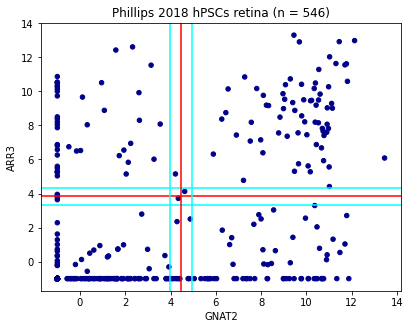

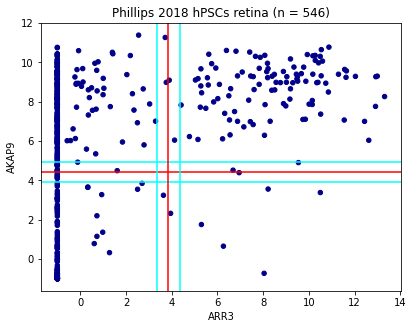

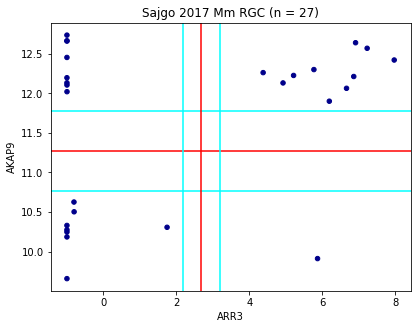

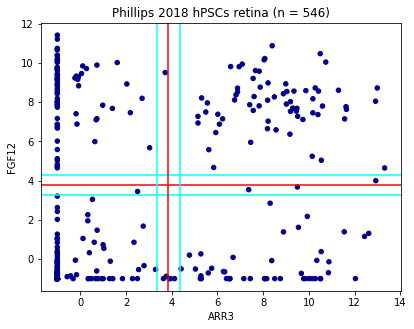

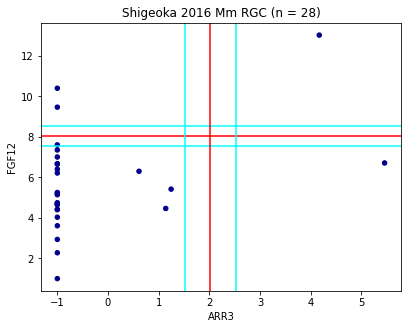

In [44]:
import sys
sys.path.append("/Users/rohan/public_html/Hegemon")
import StepMiner as smn
import HegemonUtil as hu
obj = hu.getHegemonPlots("RT29", "GNAT2", "ARR3")
hu.plotBooleanPair(obj[0])
obj = hu.getHegemonPlots("RT29", "ARR3", "AKAP9")
hu.plotBooleanPair(obj[0])
obj = hu.getHegemonPlots("RT28", "ARR3", "AKAP9")
hu.plotBooleanPair(obj[0])
obj = hu.getHegemonPlots("RT29", "ARR3", "FGF12")
hu.plotBooleanPair(obj[0])
obj = hu.getHegemonPlots("RT27", "ARR3", "FGF12")
hu.plotBooleanPair(obj[0])

<a id="cone-eval2"></a>

## Test whether boolean analysis leads to more retina-specific genes

#### Null Hypothesis (H0): There is no difference in mean expression of Gene X in retina vs. whole eye.
#### Alternate Hypothesis (H1): Mean expression of Gene X in retina > mean expression of Gene X in whole eye.

Perform a one-tailed Welch’s t-test between expression values of whole eye and and expression values in retina in Mustafi 2016 Mm bulk RNA-seq dataset for each gene.

In [940]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT14"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

atype = h.getSurvName("c tissue")
whole_eye = np.array([i for i in h.aRange() if atype[i] == "Whole Eye" or atype[i] == "eye"])
retina = np.array([i for i in h.aRange() if atype[i] == "Retina"])

genes = np.array([h.getName(i) for i in h.getAllIDs()])

corr_genes = ['AIPL1','CADM2','CPE','DST', 'FAM123A', 'GUCA1A', 'LPCAT1', 'NEUROD4','PLEKHB1', 'RCVRN', 'RXRG', 
                    'SLC40A1', 'SYT1', 'ANKRD33B', 'CDHR1', 'CPLX4', 'EGFLAM', 'GABRR2', 'IMPG1', 'MAK', 'OTX2',
                    'PRDM1', 'RD3', 'SEPT4', 'SLC6A6', 'THRB', 'ARL6', 'CERKL', 'CRX', 'EML1', 'GNAT2', 'IMPG2',
                    'MAOA', 'PDC', 'PROM1', 'RP1', 'SGIP1', 'SNAP25', 'UNC119', 'ARR3', 'CHRNA3', 'DCT', 'ENO2',
                    'GNB3','KCNV2','MPP4', 'PDE6H', 'RAPGEF4', 'RPGRIP1', 'SLC17A7', 'STX3', 'USH2A', 'CACNB2',
                    'CHRNA5', 'DLG4', 'EYS', 'GNGT2', 'LBH', 'NEUROD1', 'PEX5L', 'RBP3', 'RS1', 'SLC1A7', 'SYP',
                    'VTN', 'AKAP9', 'ARMC9', 'C8orf46', 'CADPS', 'FGF12', 'FSTL5', 'ISOC1', 'NCKAP5', 'PRICKLE2', 'SCN3B',
                    'SLC38A5', 'TRAK2', 'TUBA4A', 'COBLL1', 'FMN1', 'GALNT13', 'LGALSL', 'NPTX1', 'RALGPS2', 'SEMA3C', 
                    'STXBP5L', 'TRIM36', 'XRCC4', 'FAM57B', 'FRMPD1', 'GPC5', 'MEGF9', 'PCBP4', 'ROBO2', 'SH3GL2', 'TPD52',
                    'TTC39C']

expr = h.getExprData('ANKRD33B')
expr_we = np.array([float(expr[i]) for i in whole_eye if expr[i] != ''])
expr_re = np.array([float(expr[i]) for i in retina if expr[i] != ''])

'''
expr_we = np.array(0 if expr[i] == '' else float(expr[i]) for i in whole_eye])
expr_re = np.array(0 if expr[i] == '' else float(expr[i]) for i in retina])
'''

result = scipy.stats.ttest_ind(expr_we, expr_re, equal_var = False)
print(result.statistic)
print(result.pvalue)

-6.091897606103268
7.40333860448243e-05


In [943]:
removed = []
cones_boolean_3 = ['AIPL1','ARR3','CRX','FSTL5','GNAT2','IMPG2','MAK','PDC','RIMS2','TRIM72']
boolean_dict = {}
cones_boolean_4 = set(cones_boolean_3).difference(removed)
for i in cones_boolean_4:
    expr = h.getExprData(i)
    expr_we = np.array([float(expr[x]) for x in whole_eye if expr[x] != ''])
    expr_re = np.array([float(expr[x]) for x in retina if expr[x] != ''])
    boolean_dict[i] = scipy.stats.ttest_ind(expr_we, expr_re, equal_var = False)
print(boolean_dict)
pass_dict = {i:boolean_dict[i].pvalue for i in list(boolean_dict.keys()) if boolean_dict[i].statistic<0 and \
            boolean_dict[i].pvalue/2 < 0.05}
print(pass_dict)
print(len(boolean_dict))
print(len(pass_dict)/(len(cones_boolean_4))*100)

{'CRX': Ttest_indResult(statistic=-4.794721836978989, pvalue=0.00010415260605227076), 'GNAT2': Ttest_indResult(statistic=-7.818354087537819, pvalue=3.854750583694197e-06), 'FSTL5': Ttest_indResult(statistic=-5.77772581413144, pvalue=4.5065311316192865e-06), 'AIPL1': Ttest_indResult(statistic=-10.07827958049902, pvalue=1.0359915615014217e-10), 'PDC': Ttest_indResult(statistic=-2.5311773899377044, pvalue=0.019320605973237055), 'TRIM72': Ttest_indResult(statistic=11.59715251339977, pvalue=1.956684575957161e-10), 'IMPG2': Ttest_indResult(statistic=-4.174745288215848, pvalue=0.00041687545976010784), 'ARR3': Ttest_indResult(statistic=-9.614953893354484, pvalue=9.276928711928969e-10), 'RIMS2': Ttest_indResult(statistic=-10.5081415190043, pvalue=1.7295459651113886e-10), 'MAK': Ttest_indResult(statistic=-1.1043579453463737, pvalue=0.2894134189757086)}
{'CRX': 0.00010415260605227076, 'GNAT2': 3.854750583694197e-06, 'FSTL5': 4.5065311316192865e-06, 'AIPL1': 1.0359915615014217e-10, 'PDC': 0.019320

In [930]:
removed = ['EYS','C8orf46', 'LGALSL']
corr_dict = {}
corr_genes_2 = set(corr_genes).difference(removed)
for i in corr_genes_2:
    expr = h.getExprData(i)
    expr_we = np.array([float(expr[x]) for x in whole_eye if expr[x] != ''])
    expr_re = np.array([float(expr[x]) for x in retina if expr[x] != ''])
    corr_dict[i] = scipy.stats.ttest_ind(expr_we, expr_re, equal_var = False)
print(corr_dict)
corr_pass_dict = {i:corr_dict[i].pvalue for i in list(corr_dict.keys()) if corr_dict[i].statistic<0 and \
            corr_dict[i].pvalue/2 < 0.05}
print(corr_pass_dict)
print(len(corr_pass_dict))
print(len(corr_pass_dict)/(len(corr_genes_2))*100)

{'FRMPD1': Ttest_indResult(statistic=-11.009881341841833, pvalue=2.0766318469106886e-10), 'NPTX1': Ttest_indResult(statistic=-11.071082046195679, pvalue=4.7723272151631324e-11), 'AIPL1': Ttest_indResult(statistic=-10.07827958049902, pvalue=1.0359915615014217e-10), 'RD3': Ttest_indResult(statistic=-7.457916525887505, pvalue=2.40329491669232e-06), 'ARL6': Ttest_indResult(statistic=-0.304685932670883, pvalue=0.7629946240876735), 'DLG4': Ttest_indResult(statistic=-9.537121791822829, pvalue=3.7206381695303406e-10), 'THRB': Ttest_indResult(statistic=-5.929077740567498, pvalue=5.433417640411456e-06), 'ARMC9': Ttest_indResult(statistic=-11.344544516517336, pvalue=1.0280514434756535e-10), 'FMN1': Ttest_indResult(statistic=-3.94331581416308, pvalue=0.0005158479431538001), 'IMPG1': Ttest_indResult(statistic=-4.721341470087179, pvalue=0.00012781181176483146), 'PLEKHB1': Ttest_indResult(statistic=-4.0760481692814325, pvalue=0.0003809831807764784), 'SNAP25': Ttest_indResult(statistic=-5.059549870589

<a id="rgc"></a>

## Finding Gold Standard Genes for RGCs 

<br><a href= 'https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5998302/#:~:text=The%20expression%20of%20many%20genes,most%20widely%20utilized%20molecular%20markers'> Langer et al. 2018</a>, co-authored by M.J. Phillips, describes BRN3B (alias POU4F2), ISL1, SNCG, and RBPMS as known RGC Markers based on Dhande et al. 2015 and their own research.</br>
<br> The <a href= "https://pubmed.ncbi.nlm.nih.gov/28465430/"> Sajgo et al. 2017 paper </a> considers BRN3A and BRN3B (POU4F1 and POU4F2) to be their gold standard for RGCs.</br>
<br>We wil attempt to reproduce these results in the Rheaume et al. 2018 dataset (RT20, scRNA-seq data for RGCs) and Sajgo et al. 2017 dataset (RT28, bulk RNA-seq).</br>

In [6]:
import HegemonUtil as hu
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT20"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()

RGCTop = h.getTopGenes()

In [7]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT5"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()

RPETop = h.getTopGenes()

In [13]:
RGC = [RGCTop[i][1].upper() for i in range(200)]
RPE = [RPETop[i][1].upper() for i in range(200)]
RGC_gs = set(RGC).difference(RPE)
RGC_gs = set(RGC_gs).difference(res3)
RGC_gs = [i for i in RGC if i in RGC_gs]
print(RGC_gs)
len(RGC_gs)

['POU6F2', 'CPNE4', 'ISL2', 'TAC1', 'ISL1', 'MEIS2', 'IGF1', 'ZFHX3', 'IRX6', 'CHRNA6', 'RPRM', 'POU4F3', 'LGALS1', 'TSHZ2', 'PCDH9', 'PCDH7', 'SYNPR', 'JUN', 'BARHL2', 'ALCAM', 'IRX5', 'CPLX2', 'MGAT4C', 'FOS', 'PCDH10', 'SCG2', 'POU4F2', 'NPTX2', 'IRX4', 'VAX2', 'HSPB1', 'EBF3', 'SPARCL1', 'KITL', 'GM17750', 'TCERG1L', 'RAMP3', 'SIX3', 'PCDH8', 'LMO4', 'NECAB2', 'RGS4', 'TFAP2D', 'KCNIP4', 'DLG2', 'CPNE5', 'GAL', 'LYPD6', 'NTNG1', 'TMEM176B', 'CHCHD10', 'KCTD12', 'SERPINE2', 'RELN', 'LRP1B', 'CDH13', 'CPNE8', 'SPOCK3', 'CLIC1', 'LGALS7', 'PCDH11X', 'FGF13', 'MSTN', 'COTL1', 'MGLL', 'ID4', 'NELL1', 'ADGRA1', 'VGF', 'TRP53I11', 'SIX6', 'MGARP', 'NEGR1', 'MYO1B', 'EVC2', 'SYNDIG1L', 'CDH4', 'CAMK4', 'BRINP1', 'POU4F1', 'CITED2', 'SPARC', 'RGS7BP', 'ATP1A1', 'CD24A', 'GNAI1', 'CARTPT', 'CLU', 'PLCB1', 'NETO2', 'BTG1', 'OGFRL1', 'SEMA6A', 'SOCS2', 'AHNAK2', 'KHDRBS2', 'SYN2', 'EDIL3', 'FOXP1', 'CALN1', 'IRX2', 'VSTM2L', 'ZMAT4', 'A2ML1', 'MT3', 'ID2', 'NRGN', 'UBASH3B', 'ALDOC', 'CPLX1', 

196

In [46]:
RGC_gs = ['POU6F2', 'CPNE4', 'ISL2', 'TAC1', 'ISL1', 'MEIS2', 'IGF1', 'ZFHX3', 'IRX6', 'CHRNA6', 'RPRM', 'POU4F3', 'LGALS1', 'TSHZ2', 'PCDH9', 'PCDH7', 'SYNPR', 'JUN', 'BARHL2', 'ALCAM', 'IRX5', 'CPLX2', 'MGAT4C', 'FOS', 'PCDH10', 'SCG2', 'POU4F2', 'NPTX2', 'IRX4', 'VAX2', 'HSPB1', 'EBF3', 'SPARCL1', 'KITL', 'GM17750', 'TCERG1L', 'RAMP3', 'SIX3', 'PCDH8', 'LMO4', 'NECAB2', 'RGS4', 'TFAP2D', 'KCNIP4', 'DLG2', 'CPNE5', 'GAL', 'LYPD6', 'NTNG1', 'TMEM176B', 'CHCHD10', 'KCTD12', 'SERPINE2', 'RELN', 'LRP1B', 'CDH13', 'CPNE8', 'SPOCK3', 'CLIC1', 'LGALS7', 'PCDH11X', 'FGF13', 'MSTN', 'COTL1', 'MGLL', 'ID4', 'NELL1', 'ADGRA1', 'VGF', 'TRP53I11', 'SIX6', 'MGARP', 'NEGR1', 'MYO1B', 'EVC2', 'SYNDIG1L', 'CDH4', 'CAMK4', 'BRINP1', 'POU4F1', 'CITED2', 'SPARC', 'RGS7BP', 'ATP1A1', 'CD24A', 'GNAI1', 'CARTPT', 'CLU', 'PLCB1', 'NETO2', 'BTG1', 'OGFRL1', 'SEMA6A', 'SOCS2', 'AHNAK2', 'KHDRBS2', 'SYN2', 'EDIL3', 'FOXP1', 'CALN1', 'IRX2', 'VSTM2L', 'ZMAT4', 'A2ML1', 'MT3', 'ID2', 'NRGN', 'UBASH3B', 'ALDOC', 'CPLX1', 'GALNT14', 'NRXN3', 'RGS10', 'CPNE9', 'TRARG1', 'MARCH1', 'BC030500', 'TOX2', 'SERPINI1', 'PID1', 'RHOC', 'CBX3', 'THSD7A', 'SLC6A1', 'GM28050', 'LYPD6B', 'B3GAT2', 'ZCCHC12', 'AI593442', 'LMO1', 'PCBD1', 'RBMS3', 'NRP1', 'PDCD4', 'PCSK2', 'KLF9', 'CHST1', 'DKK3', 'SATB1', 'FAM19A2', 'RORA', 'PCDH19', 'MAGI1', 'LHFP', 'TCF4', 'SLC18A2', 'ELMO1', 'TSPAN9', 'CRHBP', 'SHANK1', 'SPHKAP', 'NRSN1', 'LIN7A', 'GABRA2', 'CASK', 'FOXP2', 'MTUS2', 'TSPAN5', 'MAST4', '2510009E07RIK', 'LRRN3', 'DKKL1', 'MDGA2', 'KLF6', 'RAB3B', 'MAB21L2', 'DPP10', 'CAMKV', 'GNG4', 'IRX3', 'E130218I03RIK', 'KCNIP1', 'LHFPL3', 'SCN1B', 'BCAS3', 'DOK5', 'CHL1', 'SYT13', 'BCAM', 'AMER2', 'NDRG2', 'DACH1', 'NREP', 'CAR10', 'MAP1A', 'RAB3C', 'TMEFF2', 'PLCB4', 'CXXC5', 'ZBTB20', 'CNTNAP2', 'PDGFA', 'KCNQ1OT1', 'CADM2', 'AS3MT', 'VAT1']
gs = ['POU4F1', 'POU4F2', 'ISL1', 'RBPMS', 'SNCG']
set(RGC_gs).intersection(gs)

{'ISL1', 'POU4F1', 'POU4F2'}

Analysing the most expressed genes in the Rheaume et al. 2017, filtering out genes identified in RPEs and cone PRs, corroborated the presence of ISL1, POU4F1 and POU4F2.

<br>Interpretation of scatter plots in next cell, from top to bottom: </br>
<ol> 
    <li>POU4F1 and POU4F2: Very high correlation between expression of these two genes. Likely to be expressed at same time.</li>
    <li>POU4F1 and ISL1: POU4F1 and ISL1 both highly expressed. POU4F1 appears to be more general than ISL1.</li>
    <li>POU4F2 and SNCG: Both highly expressed in the datase. POU4F1 appears to be more general than SNCG.</li>
    <li>POU4F2 and RBPMS: The scatter plot from Sajgo 2017 supports the assertion in Langer 2018 that RBPMS is expressed significantly later in RGCs than the other genes above.</li>
</ol>

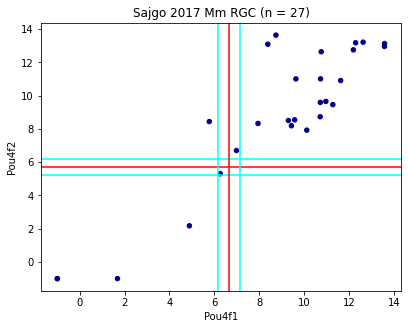

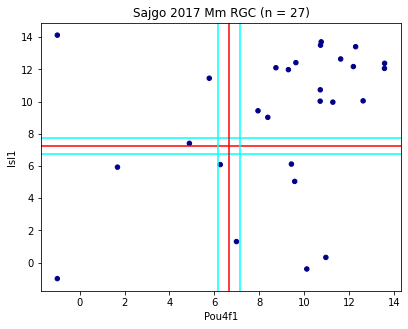

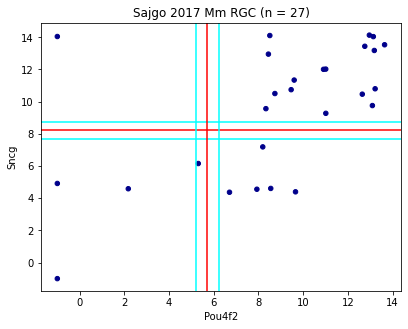

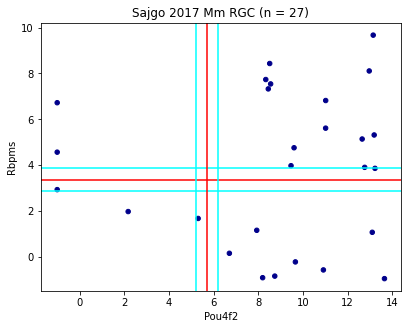

In [45]:
%matplotlib inline
obj = hu.getHegemonPlots("RT28", "Pou4f1", "Pou4f2")
hu.plotBooleanPair(obj[0])
obj = hu.getHegemonPlots("RT28", "Pou4f1", "Isl1")
hu.plotBooleanPair(obj[0])
obj = hu.getHegemonPlots("RT28", "Pou4f2", "Sncg")
hu.plotBooleanPair(obj[0])
obj = hu.getHegemonPlots("RT28", "Pou4f2", "Rbpms")
hu.plotBooleanPair(obj[0])

POU4F1 and POU4F2 are the earliest RGC-specfic marker genes. ISL1, SNCG and RBPMS are expressed later, and may be correlated with RGC subtypes. They were all verified to be RGC-specific and can be considered as the gold standard.
<br> ATOH7, used by Phillips et al., was not as expressed as highly as the others investigated in the Sajgo 2017 dataset, and was not profiled in the Rheaume 2018 dataset.</br>

<a id="rgc-bg"></a>

## Finding Bait Genes for RGCs

In [22]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT29"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()

# possible bait genes
idstr = ['AFAP1', 'CHRNA3', 'LCOR', 'RAB31', 'ELAVL2', 'OLFM2', 'SNCG', 'AKR1C1', 'EBF1', 'OLIG2', 'TAGLN3', 'ELAVL3',
         'POU4F2', 'SOX11', 'BCL7A', 'EPN2', 'PKIA', 'ATOH7', 'ELAVL4', 'PPP1R1A', 'STMN2', 'C6orf130', 'FHL1', 
         'PPFIA2', 'CELF4', 'ISL1', 'SLC17A8', 'TUBB3', 'CDKN1C', 'FNDC5', 'PTPRD', 'CNTN2', 'NPTX2', 'SLC1842']

# gold standard rgc genes
idstr1 = ['POU4F1', 'POU4F2', 'ISL1', 'RBPMS', 'SNCG']

bait_dict = {}

print(idstr1)
bait_list = itertools.permutations(idstr1, 2)
for a in bait_list:
    res1 = h.getBooleanRelations(a[0])
    res2 = h.getBooleanRelations(a[1])
    l1 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res1]
    l2 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res2]
    l3 = [i[0] for i in l1]
    l4 = [i[0] for i in l2]
    res3 = [res1[i][1] for i in range(len(res1)) \
            if (l3[i] == 2 or l3[i] == 5) and \
            (l4[i] == 3 or l4[i] == 5)]
    
    res3 = set(res3)
    res4 = list(set(idstr1).difference(set(res3))) # no. of starred genes omitted 
    bait_dict[a] = [len(res4), len(res3)] #[no. of starred genes omitted, total number of genes]
print(bait_dict)

['POU4F1', 'POU4F2', 'ISL1', 'RBPMS', 'SNCG']
{('POU4F1', 'POU4F2'): [5, 0], ('POU4F1', 'ISL1'): [5, 0], ('POU4F1', 'RBPMS'): [5, 0], ('POU4F1', 'SNCG'): [5, 0], ('POU4F2', 'POU4F1'): [5, 1], ('POU4F2', 'ISL1'): [5, 0], ('POU4F2', 'RBPMS'): [5, 0], ('POU4F2', 'SNCG'): [5, 1], ('ISL1', 'POU4F1'): [5, 2], ('ISL1', 'POU4F2'): [2, 8], ('ISL1', 'RBPMS'): [5, 0], ('ISL1', 'SNCG'): [3, 5], ('RBPMS', 'POU4F1'): [5, 0], ('RBPMS', 'POU4F2'): [5, 0], ('RBPMS', 'ISL1'): [5, 0], ('RBPMS', 'SNCG'): [5, 0], ('SNCG', 'POU4F1'): [5, 0], ('SNCG', 'POU4F2'): [3, 4], ('SNCG', 'ISL1'): [5, 0], ('SNCG', 'RBPMS'): [5, 0]}


### ISL1 and POU4F2 as bait genes

In [21]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT29"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()

res3 = getBooleanRels("ISL1", "POU4F2")
print('res3 : all')
print (" ".join(sorted(res3)))

res4 = list(set(idstr) & set(res3))
print('res4 : corr & boolean')
print (" ".join(sorted(res4)))

print('res5 :  all corr and not boolean')
res5 = list(set(idstr).difference(set(res3)))
print(" ".join(sorted(res5)))

print('res6 :  boolean and not corr')
res6 = list(set(res3).difference(set(idstr1)))
print(" ".join(sorted(res6)))

res7 = set(idstr1).difference(res3)
print("res7 : gold standard genes and not boolean")
print(" ".join(sorted(res7)))


{0: 18873, 2: 17, 3: 21, 4: 184, 5: 3}
{0: 18606, 3: 71, 4: 417, 5: 4}
res3 : all
D4S234E EBF1 ELAVL2 ELAVL4 ISL1 POU4F2 PRPH SNCG
res4 : corr & boolean
EBF1 ELAVL2 ELAVL4 ISL1 POU4F2 SNCG
res5 :  all corr and not boolean
AFAP1 AKR1C1 ATOH7 BCL7A C6orf130 CDKN1C CELF4 CHRNA3 CNTN2 ELAVL3 EPN2 FHL1 FNDC5 LCOR NPTX2 OLFM2 OLIG2 PKIA PPFIA2 PPP1R1A PTPRD RAB31 SLC17A8 SLC1842 SOX11 STMN2 TAGLN3 TUBB3
res6 :  boolean and not corr
D4S234E EBF1 ELAVL2 ELAVL4 PRPH
res7 : gold standard genes and not boolean
POU4F1 RBPMS


<a id="rgc-eval"></a>

## To check whether boolean genes are more retina-specific

In [848]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT14"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

atype = h.getSurvName("c tissue")
whole_eye = np.array([i for i in h.aRange() if atype[i] == "Whole Eye" or atype[i] == "eye"])
retina = np.array([i for i in h.aRange() if atype[i] == "Retina"])

boolean_rgc = ["EBF1", "ELAVL2", "ELAVL4", "ISL1", "POU4F2", "PRPH", "SNCG"]
removed = ["D4S234E"]
boolean_dict = {}
for i in boolean_rgc:
    expr = h.getExprData(i)
    expr_we = np.array([float(expr[x]) for x in whole_eye if expr[x] != ''])
    expr_re = np.array([float(expr[x]) for x in retina if expr[x] != ''])
    boolean_dict[i] = scipy.stats.ttest_ind(expr_we, expr_re, equal_var = False)
print(boolean_dict)
pass_dict = {i:boolean_dict[i].pvalue for i in list(boolean_dict.keys()) if boolean_dict[i].statistic<0 and \
            boolean_dict[i].pvalue/2 < 0.05}
print(pass_dict)
print(len(pass_dict))
print(len(boolean_rgc))
len(pass_dict)/len(boolean_rgc)

{'EBF1': Ttest_indResult(statistic=-2.4394144166594347, pvalue=0.021372812591487298), 'ELAVL2': Ttest_indResult(statistic=-2.6263241242426902, pvalue=0.014507171697580624), 'ELAVL4': Ttest_indResult(statistic=-3.3729005639913967, pvalue=0.0023298517057110672), 'ISL1': Ttest_indResult(statistic=-6.288118316932382, pvalue=3.880378512082901e-06), 'POU4F2': Ttest_indResult(statistic=-8.201417836593293, pvalue=2.74926927445525e-08), 'PRPH': Ttest_indResult(statistic=-1.4531148868781802, pvalue=0.17893042588166602), 'SNCG': Ttest_indResult(statistic=-2.5635420199683256, pvalue=0.02382909452675079)}
{'EBF1': 0.021372812591487298, 'ELAVL2': 0.014507171697580624, 'ELAVL4': 0.0023298517057110672, 'ISL1': 3.880378512082901e-06, 'POU4F2': 2.74926927445525e-08, 'SNCG': 0.02382909452675079}
6
7


0.8571428571428571

In [849]:
corr_rgc = ['AFAP1', 'CHRNA3', 'LCOR', 'RAB31', 'ELAVL2', 'OLFM2', 'SNCG', 'EBF1', 'OLIG2', 'TAGLN3', 'ELAVL3',
         'POU4F2', 'SOX11', 'BCL7A', 'EPN2', 'PKIA', 'ATOH7', 'ELAVL4', 'PPP1R1A', 'STMN2', 'FHL1', 
         'PPFIA2', 'CELF4', 'ISL1', 'SLC17A8', 'TUBB3', 'CDKN1C', 'FNDC5', 'PTPRD', 'CNTN2', 'NPTX2']
removed = ["AKR1C1", 'C6orf130', 'SLC1842']
corr_dict = {}
for i in corr_rgc:
    expr = h.getExprData(i)
    expr_we = np.array([float(expr[x]) for x in whole_eye if expr[x] != ''])
    expr_re = np.array([float(expr[x]) for x in retina if expr[x] != ''])
    corr_dict[i] = scipy.stats.ttest_ind(expr_we, expr_re, equal_var = False)
print(corr_dict)
pass_dict = {i:corr_dict[i].pvalue for i in list(corr_dict.keys()) if corr_dict[i].statistic<0 and \
            corr_dict[i].pvalue/2 < 0.05}
print(pass_dict)
print(len(pass_dict))
print(len(corr_rgc))
len(pass_dict)/len(corr_rgc)

{'AFAP1': Ttest_indResult(statistic=2.273095048969227, pvalue=0.030890498874457287), 'CHRNA3': Ttest_indResult(statistic=-3.7480848969818834, pvalue=0.0009521283635036185), 'LCOR': Ttest_indResult(statistic=-6.414509481766433, pvalue=8.262470816710086e-06), 'RAB31': Ttest_indResult(statistic=21.520533781394384, pvalue=1.5415968278910084e-15), 'ELAVL2': Ttest_indResult(statistic=-2.6263241242426902, pvalue=0.014507171697580624), 'OLFM2': Ttest_indResult(statistic=-4.727588289399829, pvalue=5.9338029582389164e-05), 'SNCG': Ttest_indResult(statistic=-2.5635420199683256, pvalue=0.02382909452675079), 'EBF1': Ttest_indResult(statistic=-2.4394144166594347, pvalue=0.021372812591487298), 'OLIG2': Ttest_indResult(statistic=4.415400771646888, pvalue=0.00026626209158906274), 'TAGLN3': Ttest_indResult(statistic=-0.48072924258791455, pvalue=0.6433245949774886), 'ELAVL3': Ttest_indResult(statistic=-9.871233044905361, pvalue=4.1821387894042916e-10), 'POU4F2': Ttest_indResult(statistic=-8.2014178365932

0.7096774193548387

#### Cherry Trimarchi 2009 Dataset

In [882]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT1"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

atype = h.getSurvName("c Type")
re_ganglion = np.array([i for i in h.aRange() if atype[i] == "retinal ganglion cell" or atype[i] == "retinal ganglion"])
whole_eye = np.array([i for i in h.aRange() if atype[i] != "retinal ganglion cell" or atype[i] != "retinal ganglion"])

removed = []
boolean_rgc_2 = set(boolean_rgc).difference(removed)
boolean_dict = {}
for i in boolean_rgc_2:
    print(i)
    expr = h.getExprData(i)
    expr_we = np.array([float(expr[x]) for x in whole_eye if expr[x] != ''])
    expr_rgc = np.array([float(expr[x]) for x in re_ganglion if expr[x] != ''])
    boolean_dict[i] = scipy.stats.ttest_ind(expr_we, expr_rgc, equal_var = False)
print(boolean_dict)
pass_dict = {i:boolean_dict[i].pvalue for i in list(boolean_dict.keys()) if boolean_dict[i].statistic<0 and \
            boolean_dict[i].pvalue/2 < 0.05}
print(pass_dict)
print(len(boolean_rgc_2))
len(pass_dict)/len(boolean_rgc_2)

EBF1
SNCG
PRPH
POU4F2
ELAVL4
ELAVL2
ISL1
{'EBF1': Ttest_indResult(statistic=-2.177408544166949, pvalue=0.04916233298178058), 'SNCG': Ttest_indResult(statistic=-8.133395568757923, pvalue=6.764164600406443e-07), 'PRPH': Ttest_indResult(statistic=0.07983005931804826, pvalue=0.9374079924774423), 'POU4F2': Ttest_indResult(statistic=-6.712362593939797, pvalue=9.58897476025454e-06), 'ELAVL4': Ttest_indResult(statistic=-2.1898487221835397, pvalue=0.048212390789025304), 'ELAVL2': Ttest_indResult(statistic=-1.624118712147291, pvalue=0.1291595642553419), 'ISL1': Ttest_indResult(statistic=-5.07756806033779, pvalue=0.00017041808069027427)}
{'EBF1': 0.04916233298178058, 'SNCG': 6.764164600406443e-07, 'POU4F2': 9.58897476025454e-06, 'ELAVL4': 0.048212390789025304, 'ISL1': 0.00017041808069027427}
7


0.7142857142857143

In [886]:
removed = ['CELF4','SLC17A8']
corr_rgc_2 = set(corr_rgc).difference(removed)
corr_dict = {}
for i in corr_rgc_2:
    expr = h.getExprData(i)
    expr_we = np.array([float(expr[x]) for x in whole_eye if expr[x] != ''])
    expr_rgc = np.array([float(expr[x]) for x in re_ganglion if expr[x] != ''])
    corr_dict[i] = scipy.stats.ttest_ind(expr_we, expr_rgc, equal_var = False)
print(corr_dict)
pass_dict = {i:corr_dict[i].pvalue for i in list(corr_dict.keys()) if corr_dict[i].statistic<0 and \
            corr_dict[i].pvalue/2 < 0.05}
print(pass_dict)
print(len(corr_rgc_2))
len(pass_dict)/len(corr_rgc_2)

{'TAGLN3': Ttest_indResult(statistic=-3.945969635308369, pvalue=0.0010398630190602799), 'TUBB3': Ttest_indResult(statistic=-16.810516551365822, pvalue=4.459265986191725e-37), 'EPN2': Ttest_indResult(statistic=-1.5814468148584404, pvalue=0.1373083253816836), 'RAB31': Ttest_indResult(statistic=-0.8678423360617501, pvalue=0.4007736695426931), 'ATOH7': Ttest_indResult(statistic=-0.3348606869379735, pvalue=0.7428621943128364), 'AFAP1': Ttest_indResult(statistic=-3.6808306268544335, pvalue=0.0020310196417124616), 'CHRNA3': Ttest_indResult(statistic=-0.755071608191934, pvalue=0.46376310058892833), 'FNDC5': Ttest_indResult(statistic=-0.6193193435060996, pvalue=0.5457969273524985), 'OLFM2': Ttest_indResult(statistic=-1.3964853673635236, pvalue=0.18481321451244911), 'SNCG': Ttest_indResult(statistic=-8.133395568757923, pvalue=6.764164600406443e-07), 'EBF1': Ttest_indResult(statistic=-2.177408544166949, pvalue=0.04916233298178058), 'SOX11': Ttest_indResult(statistic=-2.8740529325305206, pvalue=0.

0.5172413793103449

<a id="rpe"></a>

## Finding Gold Standard Genes for RPE Cells

<br>Marker genes for retinal pigment epithelium (RPE) cells are relatively well-studied due to their importance in age-related macular degeneration (AMD). Death of RPEs is the leading cause of the dry form of AMD. </br>
<br>RPEs grown in vitro from embryonic stem cells have been tested with limited success to treat AMD.</br>

<br>From Liu et al. 2019: (https://www.nature.com/articles/s42003-019-0430-6#ref-CR30) </br>



In [45]:
rpe_sig_1 = "RPE65 ABCA4 CA14 PLD5 TTLL4 SLC6A20 LRAT SLC45A2 SLC2A12 STRIP2 SLC4A2 TYRP1 TRPM3 RGR BEST1 TYR MFRP RDH5 DCT OTX2 RLBP1 BCMO1 RAX CRX SLC16A8"
rpe_sig_1 = rpe_sig_1.split(sep=" ")
len(rpe_sig_1)

25

From Strunnikova et al. 2010 (158 "signature genes" from differential epxression and PCA analysis) (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2876890/):

In [31]:
rpe_sig_2 = 'ADAM9 ADCY9 AHR ALDH1A3 ANKRD12 APLP1 ARL6IP1 ARMC9 ASAH1 ATF1 BAT2D1 BCLAF1 BDH2 BEST1 BHLHB3 BMP4 C1orf108 C20orf19 CALU CDH1 CDH3 CDO1 CHRNA3  CLCN4 COL8A2 COX15 CRIM1 CRX CSPG5 CTBP2 CYP20A1 DAP3 DCT DCUN1D4 DEGS1 DHPS DIXDC1 DMXL1 DNAJB14DUSP4 DZIP1 EFEMP1   EFHC1 EID1 ENPP2 FADS1 FAM18B FGFR2 FOXD1 FRZB GAS1 GEM GJA1 GOLPH3L GPM6B GPNMB GPR143 GRAMD3 GULP1 HSP90B1 IFT74 IGF2BP2 ITGAV ITM2B KLHL21 KLHL24 LAMP2 LAPTM4B LGALS8 LHX2 LIMCH1 LIN7C LOXL1 LSR MAB21L1 MANEA MAP9 MBNL2 MED8 MET MFAP3L MPDZ MPHOSPH9 MPHOSPH9 MYRIP NAV3 NDC80 NEDD4L NOL8 NRIP1 NUDT4 OSTM1 PAK1IP1 PCYOX1 PDPN PDZD8 PHACTR2 PITPNA PKNOX2 PLAG1 PLCB4 PLOD2 PRNP PSME4 PTGDS PTPRG RAB38 BM34 RBP1 RDH11 RHOBTB3 RNF13 RPE65 RRAGD SAS10 SCAMP1 SDC2 SEMA3C SERPINF1 SFRP5 SGK3 SIL1 SILV SIX3 SLC16A1 SLC16A1 SLC16A1 SLC16A4 SLC24A1 SLC39A6 SLC4A2 SLC6A15 SLC6A20 SMAD6 SMC3 SORBS2 SOSTDC1 SPAST STAM2 STCH SULF1 SULF1 TAX1BP1 TFPI2 TIMP3 TRPM1 TTLL4 TTR TYRP1 UBL3 USP34 VDP VEGFA WASL WWC2 WWTR1 ZNF19'
rpe_sig_2 = rpe_sig_2.split(sep=" ")

From Liao et al. 2010 (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3115666/):

In [47]:
rpe_sig_3 = ["PAX6", "MITF", "OTX2", "PEDF", "BEST1", "ZO1", "RPE65", "RGR", "LRAT", "CRALBP"]

Comparing with top genes in Kuroda 2017 dataset (scRNA-seq RPE data)

In [134]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT5"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()

RPETop = h.getTopGenes()

In [241]:
cone = ['ANKRD33B', 'ARR3', 'C8orf46', 'CERKL', 'CPLX4', 'DCT', 'EGFLAM', 'EYS', 'FAM123A', 'FGF12', 'FMN1', 'FRMPD1', 'GNAT2', 'GNGT2', 'ISOC1', 'MAOA', 'NCKAP5', 'NEUROD4', 'NPTX1', 'PDE6H', 'PEX5L', 'PRDM1', 'PRICKLE2', 'RALGPS2', 'RAPGEF4', 'RD3', 'RPGRIP1', 'RS1', 'RXRG', 'SEMA3C', 'SH3GL2', 'SLC1A7', 'SLC40A1', 'SYP', 'THRB', 'TUBA4A']
#above cone genes from boolean analysis
RPE = [i[1] for i in RPETop[0:200]]
RPE_gs = set(RPE).difference(RGC)
RPE_gs = set(RPE_gs).difference(cone)
RPE_gs = [i for i in RPE if i in RPE_gs]
print(RPE_gs)
len(RPE_gs)

['FRZB', 'OPCML', 'SLC6A20', 'FRZB', 'SMOC2', 'BMP7', 'WFDC1', 'KRT19', 'SOSTDC1', 'WFIKKN2', 'KCNJ13', 'SLC6A13', 'PEG3', 'RPE65', 'LINC00645', 'SLC39A12', 'BEST1', 'GPM6B', 'TTR', 'XIST', 'TFPI2', 'PARM1', 'SOX11', 'BMP7', 'ERMN', 'SLC26A7', 'PEG3', 'TMEM255A', 'FGFR2', 'RPS4Y1', 'SFRP5', 'KCNJ13', 'GPM6B', 'SOX11', 'TRPM1', 'AQP1', 'TRPM3', 'TRPM1', 'CDH19', 'PSG1', 'RGR', 'ADAM28', 'TRPM3', 'SLC6A20', 'FRZB', 'TRPM1', 'SLC30A10', 'IFI44L', 'CXCL14', 'PTH', 'BEST1', 'ELN', 'BEST1', 'TFPI2', 'GPM6B', 'SLC35D3', 'COL9A3', 'AQP1', 'TF', '---', 'NELL2', 'FGFR2', 'HMGCS2', 'PCDH17', 'BCHE', 'TF', 'CLDN19', 'SHOX2', 'LOC100507472', 'ITGA4', 'CYTL1', 'MEGF6', 'NPPB', 'XIST', 'CDKN1C', 'USP9Y', 'PSG4', 'SOX6', 'ABCB5', 'ATP8A1', 'CXCL14', 'SLC38A11', 'DPP6', 'CDH11', 'C1orf168', 'PTGDS', 'KRT33A', 'EIF1AY', 'CYYR1', 'SERPINF1', 'PSG5', 'XIST', 'TXLNGY', 'UNC5D', 'SOX6', 'PTPRZ1', 'KL', 'KIF21B', 'TYR', 'PCDH17', 'PMEL', 'PLA1A', 'ERAP2', 'TNNC1', 'COL14A1', 'PSG7', 'SFRP4', 'BLOC1S1-RDH5', 

195

In [256]:
all = x1.union(x2).union(x3)
print(set(rpe_sig_1).intersection(rpe_sig_2).intersection(rpe_sig_3))
x1 = (set(rpe_sig_1).intersection(RPE_gs))
print(x1)
x2 = (set(rpe_sig_2).intersection(RPE_gs))
print(x2)
x3 = set(rpe_sig_3).intersection(RPE_gs)
print(x3)

y = [i for i in all if (i in x1.intersection(x2)) or \
     (i in x2.intersection(x3)) or \
     (i in x1.intersection(x3))]

y


{'BEST1', 'RPE65'}
{'TYRP1', 'RPE65', 'SLC6A20', 'TYR', 'BCMO1', 'SLC16A8', 'RGR', 'TTLL4', 'CA14', 'TRPM3', 'ABCA4', 'BEST1'}
{'TYRP1', 'RPE65', 'PTGDS', 'SLC6A20', 'TTR', 'CDH1', 'GPM6B', 'TFPI2', 'SFRP5', 'CHRNA3', 'CDH3', 'SULF1', 'FGFR2', 'TTLL4', 'BEST1', 'SERPINF1', 'SOSTDC1', 'FRZB', 'TRPM1'}
{'BEST1', 'RPE65', 'RGR'}


['RPE65', 'SLC6A20', 'RGR', 'BEST1', 'TYRP1', 'TTLL4']

PMEL, used by Phillips 2018, is more generally expressed as it produces melanin throughout the body. Hence, it is not identified as unique to RPEs by the papers above, though it is highly expressed in the Kuroda 2017 dataset.

<a id="rpe-boolean"></a>

## Finding Bait Genes for RPEs

In [10]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT29"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

idstr = 'AAMP ADAM9 AEN ALDH1A3 AMOTL2 ANXA2 APOE ARF3 ARID5B ARL5B ATPAF2 B4GALT4 BEST1 BFSP2 C11orf9 C1QTNF5 CA2 CDC25B CDKN1A CDR1 CERS2 CERS3 CERS4 CERSS CERS6 CERS7 CERS8 CERS9 CERS10 CERS11 CERS12 CERS13 CERS14 CERS15 CERS16 CERS17 CERS18 CERS19 CERS20 CERS21 ENPP2 EPAS1 FAT1 FAT4 FBN1 FBN2 FEN1 FLJ44635 FLNA FLRT2 FLRT3 FRZB GBF1 GEM GJA1 GOT2 GPC4 GPNMB MTRNR2L1 SERPINF1 HDAC5 MTRNR2L10 SESN3 HIPK3 MTRNR2L4 SLC35A4 HSD17B14 MTRNR2L6 SLC4A10 HSD17B2 NEBL SLC4A2 HSPB8 NOTCH2 SLC7A8 INO80D NR4A3 SLIT3 INPP5A OC90 SNAP47 ITGAV OSBP2 SPARC KATNB1 PITPNA SPOCK1 LAMB2 PLD3 SPOCK3 LATS2 PMEL SQSTM1 LRRC20 PRPF3 STK36 LRRC59 PSAP STS LRRN1 RPL41 RLBP1 SURF4 MAP2K1 RPS27 TEX261 MFAP3L SCG2 THBS1 MFRP SEC61A1 TIMP3 MN1 SEPT8 TMEM104 TMEM8B TNFRSF12A TPP1 TPX2 TRPM3 TXNDC5 TYR TYRP1 TPRM3 UTRN VCL ZNF202 ZNF460 ZNF609 ZNF768'
idstr = idstr.split(sep = ' ')
idstr.sort()

idstr1 = ['ALDH1A3', 'RLBP1', 'RPE65', 'SLC6A20', 'RGR', 'BEST1', 'TYRP1', 'TTLL4', 'PMEL']

bait_dict = getBaitStats("/Users/rohan/public_html/Hegemon/explore.conf", 'RT29', idstr1, sthr=2, pthr=0.35)

print([i for i in bait_dict.iteritems() if i[1][1] != 0])
#[no. of starred genes omitted, total number of genes]

['ALDH1A3', 'RLBP1', 'RPE65', 'SLC6A20', 'RGR', 'BEST1', 'TYRP1', 'TTLL4', 'PMEL']
{('ALDH1A3', 'RLBP1'): [9, 0], ('ALDH1A3', 'RPE65'): [9, 0], ('ALDH1A3', 'SLC6A20'): [9, 0], ('ALDH1A3', 'RGR'): [9, 0], ('ALDH1A3', 'BEST1'): [9, 0], ('ALDH1A3', 'TYRP1'): [9, 0], ('ALDH1A3', 'TTLL4'): [9, 0], ('ALDH1A3', 'PMEL'): [9, 0], ('RLBP1', 'ALDH1A3'): [9, 0], ('RLBP1', 'RPE65'): [9, 0], ('RLBP1', 'SLC6A20'): [9, 0], ('RLBP1', 'RGR'): [9, 0], ('RLBP1', 'BEST1'): [9, 0], ('RLBP1', 'TYRP1'): [9, 0], ('RLBP1', 'TTLL4'): [9, 0], ('RLBP1', 'PMEL'): [9, 0], ('RPE65', 'ALDH1A3'): [9, 0], ('RPE65', 'RLBP1'): [9, 0], ('RPE65', 'SLC6A20'): [9, 0], ('RPE65', 'RGR'): [9, 0], ('RPE65', 'BEST1'): [9, 0], ('RPE65', 'TYRP1'): [9, 0], ('RPE65', 'TTLL4'): [9, 0], ('RPE65', 'PMEL'): [9, 0], ('SLC6A20', 'ALDH1A3'): [9, 5], ('SLC6A20', 'RLBP1'): [8, 187], ('SLC6A20', 'RPE65'): [7, 239], ('SLC6A20', 'RGR'): [7, 658], ('SLC6A20', 'BEST1'): [9, 12], ('SLC6A20', 'TYRP1'): [9, 15], ('SLC6A20', 'TTLL4'): [9, 43], ('SLC6A2

In [17]:
# Similar to false negative
print("(Gene A, Gene B) : [no. of  gold standard genes missed, total number of genes]")
print("\n".join([str(i) for i in bait_dict.items() if i[1][1] != 0]))

(Gene A, Gene B) : [no. of  gold standard genes missed, total number of genes]
(('SLC6A20', 'ALDH1A3'), [9, 5])
(('SLC6A20', 'RLBP1'), [8, 187])
(('SLC6A20', 'RPE65'), [7, 239])
(('SLC6A20', 'RGR'), [7, 658])
(('SLC6A20', 'BEST1'), [9, 12])
(('SLC6A20', 'TYRP1'), [9, 15])
(('SLC6A20', 'TTLL4'), [9, 43])
(('SLC6A20', 'PMEL'), [9, 5])
(('RGR', 'RLBP1'), [7, 81])
(('RGR', 'RPE65'), [9, 30])
(('RGR', 'SLC6A20'), [9, 101])
(('RGR', 'BEST1'), [9, 2])
(('RGR', 'TTLL4'), [9, 4])
(('BEST1', 'TYRP1'), [7, 2])
(('BEST1', 'PMEL'), [8, 1])
(('TYRP1', 'PMEL'), [7, 4])
(('PMEL', 'TYRP1'), [7, 4])


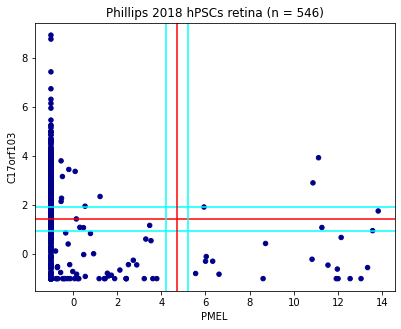

In [381]:
obj = hu.getHegemonPlots("RT29", "PMEL", "C17orf103")
hu.plotBooleanPair(obj[0])

In [384]:
print(bait_dict)

{('RPE65', 'SLC6A20'): [7, 0], ('RPE65', 'RGR'): [7, 0], ('RPE65', 'BEST1'): [7, 0], ('RPE65', 'TYRP1'): [7, 0], ('RPE65', 'TTLL4'): [7, 0], ('RPE65', 'PMEL'): [7, 0], ('SLC6A20', 'RPE65'): [5, 2], ('SLC6A20', 'RGR'): [7, 0], ('SLC6A20', 'BEST1'): [7, 0], ('SLC6A20', 'TYRP1'): [7, 0], ('SLC6A20', 'TTLL4'): [7, 0], ('SLC6A20', 'PMEL'): [7, 0], ('RGR', 'RPE65'): [7, 0], ('RGR', 'SLC6A20'): [7, 0], ('RGR', 'BEST1'): [7, 0], ('RGR', 'TYRP1'): [7, 0], ('RGR', 'TTLL4'): [7, 0], ('RGR', 'PMEL'): [7, 0], ('BEST1', 'RPE65'): [7, 0], ('BEST1', 'SLC6A20'): [7, 0], ('BEST1', 'RGR'): [7, 0], ('BEST1', 'TYRP1'): [7, 0], ('BEST1', 'TTLL4'): [7, 0], ('BEST1', 'PMEL'): [7, 0], ('TYRP1', 'RPE65'): [7, 0], ('TYRP1', 'SLC6A20'): [7, 0], ('TYRP1', 'RGR'): [7, 0], ('TYRP1', 'BEST1'): [7, 0], ('TYRP1', 'TTLL4'): [7, 0], ('TYRP1', 'PMEL'): [7, 0], ('TTLL4', 'RPE65'): [7, 0], ('TTLL4', 'SLC6A20'): [7, 0], ('TTLL4', 'RGR'): [7, 0], ('TTLL4', 'BEST1'): [7, 0], ('TTLL4', 'TYRP1'): [7, 0], ('TTLL4', 'PMEL'): [7, 0

In [321]:
bait_dict_2 = [i for i in list(bait_dict.keys()) if bait_dict[i][0] < 8 and bait_dict[i][1] > 1]
bait_dict_2

[('SLC6A20', 'RPE65'),
 ('SLC6A20', 'RGR'),
 ('SLC6A20', 'BEST1'),
 ('RGR', 'SLC6A20'),
 ('TYRP1', 'PMEL'),
 ('PMEL', 'TYRP1')]

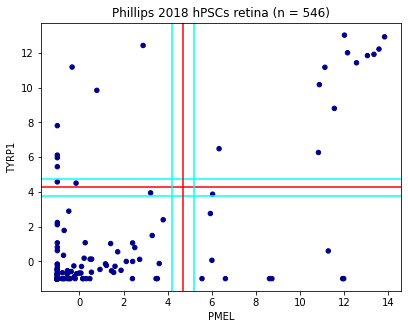

In [427]:
obj = hu.getHegemonPlots("RT29", "PMEL", "TYRP1")
hu.plotBooleanPair(obj[0])
#high corr

In [50]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT29"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()
res1 = h.getBooleanRelations('PMEL')
res2 = h.getBooleanRelations('RPE65')

l1 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res1]
l2 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res2]
l3 = [i[0] for i in l1]
l4 = [i[0] for i in l2]
print (dict((x,l3.count(x)) for x in set(l3)))
print (dict((x,l4.count(x)) for x in set(l4)))
res3 = [res1[i][1] for i in range(len(res1)) \
    if (l3[i] == 3 or l3[i] == 5 or l4[i] == 3 or l4[i] == 5)]
print('res3 : all')
print (" ".join(sorted(res3)))

{0: 18341, 2: 2, 3: 9, 4: 744, 5: 2}
{0: 19057, 3: 40, 5: 1}
res3 : all
AK1 AP2M1 ARF4 B4GALT1 BLOC1S1 BMS1 CCDC104 CCPG1 DDIT3 DIXDC1 DNTTIP2 EEF2 EGR1 EIF1AX ELOVL7 ETNK1 FOSB FRG1 GNAS GOLGA4 GSTK1 IGF2BP2 IL6ST MDK NEDD8 NSFL1C PMEL PRKAR1A PSMC2 PSMD8 RBM23 RBP1 RPE65 RWDD1 SAT1 SCAF11 SDSL SEC22B SMC5 SPARC SPATS2L SRSF7 TLK1 TMEM230 TMEM98 TMSB10 TRPM3 TXN2 TYRP1 VPS29 VPS35 YIPF3


In [113]:
print(set(res3).intersection(rpe_sig_1))
print(set(res3).intersection(rpe_sig_2))
print(set(res3).intersection(rpe_sig_3))
print(sorted(res3))

{'TRPM3', 'RPE65', 'TYRP1'}
{'RBP1', 'DIXDC1', 'RPE65', 'TYRP1', 'IGF2BP2'}
{'RPE65'}
['AK1', 'AP2M1', 'ARF4', 'B4GALT1', 'BLOC1S1', 'BMS1', 'CCDC104', 'CCPG1', 'DDIT3', 'DIXDC1', 'DNTTIP2', 'EEF2', 'EGR1', 'EIF1AX', 'ELOVL7', 'ETNK1', 'FOSB', 'FRG1', 'GNAS', 'GOLGA4', 'GSTK1', 'IGF2BP2', 'IL6ST', 'MDK', 'NEDD8', 'NSFL1C', 'PMEL', 'PRKAR1A', 'PSMC2', 'PSMD8', 'RBM23', 'RBP1', 'RPE65', 'RWDD1', 'SAT1', 'SCAF11', 'SDSL', 'SEC22B', 'SMC5', 'SPARC', 'SPATS2L', 'SRSF7', 'TLK1', 'TMEM230', 'TMEM98', 'TMSB10', 'TRPM3', 'TXN2', 'TYRP1', 'VPS29', 'VPS35', 'YIPF3']


In [116]:
res4 = h.getBooleanRelations("DIXDC1")
l5 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res4]
l6 = [i[0] for i in l5]
print (dict((x,l6.count(x)) for x in set(l6)))
res6 = [res4[i][1] for i in range(len(res4)) \
        if (l6[i] == 2 or l6[i] == 5)]
print(sorted(res6))

{0: 14830, 1: 5, 2: 2311, 3: 339, 4: 19, 5: 1594}
['A1CF', 'A2M', 'A2ML1', 'AADACL3', 'AADAT', 'AARS', 'AARS2', 'AARSD1', 'AASDH', 'AASS', 'AATF', 'ABCA1', 'ABCA13', 'ABCA4', 'ABCA5', 'ABCA7', 'ABCA9', 'ABCB5', 'ABCC5', 'ABCD3', 'ABCD4', 'ABCF1', 'ABCF2', 'ABCF3', 'ABCG1', 'ABHD11', 'ABHD12B', 'ABHD15', 'ABHD2', 'ABI1', 'ABI2', 'ABL2', 'ABRA', 'ACACA', 'ACAD11', 'ACAD9', 'ACADSB', 'ACAP2', 'ACBD4', 'ACBD5', 'ACD', 'ACOT11', 'ACOT13', 'ACOX1', 'ACPP', 'ACSL3', 'ACSL6', 'ACSM2A', 'ACSS3', 'ACTN1', 'ACTR10', 'ACTR5', 'ACVR2A', 'ACVRL1', 'ADAM17', 'ADAM19', 'ADAM20', 'ADAM33', 'ADAM9', 'ADAMTS17', 'ADAMTS2', 'ADAMTS4', 'ADAMTSL2', 'ADAMTSL5', 'ADAP2', 'ADARB1', 'ADARB2', 'ADAT2', 'ADCY2', 'ADCY6', 'ADH4', 'ADIPOQ', 'ADIPOR1', 'ADM2', 'ADORA2B', 'ADRA1A', 'ADRBK2', 'ADSL', 'AEBP2', 'AFAP1L1', 'AFF1', 'AFF3', 'AFTPH', 'AGAP1', 'AGAP5', 'AGAP9', 'AGFG1', 'AGL', 'AGMO', 'AGPAT6', 'AHCYL2', 'AHR', 'AHRR', 'AHSA1', 'AICDA', 'AIFM2', 'AIG1', 'AIM1', 'AIMP1', 'AIPL1', 'AIRE', 'AJUBA', 'AK1', 'AK2'

In [117]:
rpe_boolean = set(res3).intersection(res6)
print(rpe_boolean)

{'GOLGA4', 'ELOVL7', 'AK1', 'SDSL', 'SEC22B', 'FRG1', 'PSMC2', 'DNTTIP2', 'ETNK1', 'BMS1', 'SMC5', 'RPE65', 'TMEM230', 'SPATS2L', 'SCAF11', 'DIXDC1', 'YIPF3', 'RBM23', 'CCPG1', 'B4GALT1', 'FOSB', 'NSFL1C'}


In [35]:
rpe_boolean = {'GOLGA4', 'ELOVL7', 'AK1', 'SDSL', 'SEC22B', 'FRG1', 'PSMC2', 'DNTTIP2', 'ETNK1', 'BMS1', 'SMC5', 'RPE65', 'TMEM230', 'SPATS2L', 'SCAF11', 'DIXDC1', 'YIPF3', 'RBM23', 'CCPG1', 'B4GALT1', 'FOSB', 'NSFL1C'}
print(" ".join(sorted(rpe_boolean)))

AK1 B4GALT1 BMS1 CCPG1 DIXDC1 DNTTIP2 ELOVL7 ETNK1 FOSB FRG1 GOLGA4 NSFL1C PSMC2 RBM23 RPE65 SCAF11 SDSL SEC22B SMC5 SPATS2L TMEM230 YIPF3


In [54]:
x = "AK1 B4GALT1 BMS1 CCPG1 DIXDC1 DNTTIP2 ELOVL7 ETNK1 FOSB FRG1 GOLGA4 NSFL1C PSMC2 RBM23 RPE65 SCAF11 SDSL SEC22B SMC5 SPATS2L TMEM230 YIPF3"
x.split()
corr_rpe = ['AAMP', 'ADAM9', 'AEN', 'ALDH1A3', 'AMOTL2', 'ANXA2', 'APOE', 'ARF3', 'ARID5B', 'ARL5B', 'ATPAF2',
            'B4GALT4', 'BEST1', 'BFSP2', 'C11orf9', 'C1QTNF5', 'CA2', 'CDC25B', 'CDKN1A', 'CDR1', 'CERS10', 
            'CERS11', 'CERS12', 'CERS13', 'CERS14', 'CERS15', 'CERS16', 'CERS17', 'CERS18', 'CERS19', 'CERS2',
            'CERS20', 'CERS21', 'CERS3', 'CERS4', 'CERS6', 'CERS7', 'CERS8', 'CERS9', 'CERS5', 'ENPP2', 'EPAS1',
            'FAT1', 'FAT4', 'FBN1', 'FBN2', 'FEN1', 'FLJ44635', 'FLNA', 'FLRT2', 'FLRT3', 'FRZB', 'GBF1', 'GEM',
            'GJA1', 'GOT2', 'GPC4', 'GPNMB', 'HDAC5', 'HIPK3', 'HSD17B14', 'HSD17B2', 'HSPB8', 'INO80D', 'INPP5A', 
            'ITGAV', 'KATNB1', 'LAMB2', 'LATS2', 'LRRC20', 'LRRC59', 'LRRN1', 'MAP2K1', 'MFAP3L', 'MFRP', 'MN1',
            'MTRNR2L1', 'MTRNR2L10', 'MTRNR2L4', 'MTRNR2L6', 'NEBL', 'NOTCH2', 'NR4A3', 'OC90', 'OSBP2', 'PITPNA',
            'PLD3', 'PMEL', 'PRPF3', 'PSAP', 'RPL41', 'RPS27', 'SCG2', 'SEC61A1', 'SEPT8', 'SERPINF1', 'SESN3', 
            'SLC35A4', 'SLC4A10', 'SLC4A2', 'SLC7A8', 'SLIT3', 'SNAP47', 'SPARC', 'SPOCK1', 'SPOCK3', 'SQSTM1',
            'STK36', 'STS', 'SURF4', 'TEX261', 'THBS1', 'TIMP3', 'TMEM104', 'TMEM8B', 'TNFRSF12A', 'TPP1', 
            'TPRM3', 'TPX2', 'TRPM3', 'TXNDC5', 'TYR', 'TYRP1', 'UTRN', 'VCL', 'ZNF202', 'ZNF460', 'ZNF609','ZNF768']
set(x).intersection(rpe_sig_2)

set()

<a id="rpe-eval"></a>

## Evaluation

### Test whether boolean analysis leads to more retina-specific genes

In [720]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT14"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

atype = h.getSurvName("c tissue")
whole_eye = np.array([i for i in h.aRange() if atype[i] == "Whole Eye" or atype[i] == "eye"])
retina = np.array([i for i in h.aRange() if atype[i] == "Retina"])

rpe_boolean = np.array(['SPATS2L', 'RPE65', 'BMS1', 'ETNK1', 'SDSL', 'SCAF11', 'FRG1', 'TMEM230', 'PSMC2', 'AK1', 'DNTTIP2', 'GOLGA4', 'FOSB', 'RBM23', 'DIXDC1', 'NSFL1C', 'SMC5', 'YIPF3', 'CCPG1', 'SEC22B', 'ELOVL7', 'B4GALT1'])
removed = ['TMEM230','RBM23']
rpe_boolean2 = set(rpe_boolean).difference(removed)
boolean_dict = {}
for i in rpe_boolean2:
    expr = h.getExprData(i)
    expr_we = np.array([float(expr[x]) for x in whole_eye if expr[x] != ''])
    expr_re = np.array([float(expr[x]) for x in retina if expr[x] != ''])
    boolean_dict[i] = scipy.stats.ttest_ind(expr_we, expr_re, equal_var = False)
print(boolean_dict)
pass_dict = {i:boolean_dict[i].pvalue for i in list(boolean_dict.keys()) if boolean_dict[i].statistic<0 and \
            boolean_dict[i].pvalue/2 < 0.05}
print(pass_dict)
print(len(rpe_boolean2))
len(pass_dict)/len(rpe_boolean2)

{'SPATS2L': Ttest_indResult(statistic=6.772484254768264, pvalue=2.3079328186147204e-06), 'RPE65': Ttest_indResult(statistic=8.162918529054794, pvalue=6.950920722238394e-09), 'BMS1': Ttest_indResult(statistic=-5.368694977855306, pvalue=3.80747104083027e-05), 'DIXDC1': Ttest_indResult(statistic=-9.977009839726858, pvalue=7.967694997947326e-10), 'ETNK1': Ttest_indResult(statistic=-9.158232980889183, pvalue=2.1321966359817124e-08), 'SDSL': Ttest_indResult(statistic=0.0746924744995089, pvalue=0.9409906518579878), 'SCAF11': Ttest_indResult(statistic=-4.235891610758398, pvalue=0.0005215416687539397), 'FRG1': Ttest_indResult(statistic=5.924040519203491, pvalue=2.444620701617347e-06), 'NSFL1C': Ttest_indResult(statistic=2.782086720767491, pvalue=0.01598531777352839), 'SMC5': Ttest_indResult(statistic=-3.5036710034400174, pvalue=0.0015690464315493064), 'PSMC2': Ttest_indResult(statistic=4.089401904850355, pvalue=0.000617229871799575), 'AK1': Ttest_indResult(statistic=0.583990914212905, pvalue=0.

0.4

In [1000]:
corr_rpe = ['AAMP', 'ADAM9', 'AEN', 'ALDH1A3', 'AMOTL2', 'ANXA2', 'APOE', 'ARF3', 'ARID5B', 'ARL5B', 'ATPAF2',
            'B4GALT4', 'BEST1', 'BFSP2', 'C11orf9', 'C1QTNF5', 'CA2', 'CDC25B', 'CDKN1A', 'CDR1', 'CERS10', 
            'CERS11', 'CERS12', 'CERS13', 'CERS14', 'CERS15', 'CERS16', 'CERS17', 'CERS18', 'CERS19', 'CERS2',
            'CERS20', 'CERS21', 'CERS3', 'CERS4', 'CERS6', 'CERS7', 'CERS8', 'CERS9', 'CERS5', 'ENPP2', 'EPAS1',
            'FAT1', 'FAT4', 'FBN1', 'FBN2', 'FEN1', 'FLJ44635', 'FLNA', 'FLRT2', 'FLRT3', 'FRZB', 'GBF1', 'GEM',
            'GJA1', 'GOT2', 'GPC4', 'GPNMB', 'HDAC5', 'HIPK3', 'HSD17B14', 'HSD17B2', 'HSPB8', 'INO80D', 'INPP5A', 
            'ITGAV', 'KATNB1', 'LAMB2', 'LATS2', 'LRRC20', 'LRRC59', 'LRRN1', 'MAP2K1', 'MFAP3L', 'MFRP', 'MN1',
            'MTRNR2L1', 'MTRNR2L10', 'MTRNR2L4', 'MTRNR2L6', 'NEBL', 'NOTCH2', 'NR4A3', 'OC90', 'OSBP2', 'PITPNA',
            'PLD3', 'PMEL', 'PRPF3', 'PSAP', 'RPL41', 'RPS27', 'SCG2', 'SEC61A1', 'SEPT8', 'SERPINF1', 'SESN3', 
            'SLC35A4', 'SLC4A10', 'SLC4A2', 'SLC7A8', 'SLIT3', 'SNAP47', 'SPARC', 'SPOCK1', 'SPOCK3', 'SQSTM1',
            'STK36', 'STS', 'SURF4', 'TEX261', 'THBS1', 'TIMP3', 'TMEM104', 'TMEM8B', 'TNFRSF12A', 'TPP1', 
            'TPRM3', 'TPX2', 'TRPM3', 'TXNDC5', 'TYR', 'TYRP1', 'UTRN', 'VCL', 'ZNF202', 'ZNF460', 'ZNF609','ZNF768']
removed = ['CERS10', 'CERS11', 'CERS12', 'CERS13', 'CERS14', 'CERS15', 'CERS16', 'CERS17', 'CERS18', 'CERS19', 'CERS2',
           'CERS20', 'CERS21', 'CERS3', 'CERS4', 'CERS6', 'CERS7', 'CERS8', 'CERS9', 'CERS5','TPRM3']
corr_rpe_2 = set(corr_rpe).difference(removed)
corr_dict = {}
for i in corr_rpe_2:
    print(i)
    expr = h.getExprData(i)
    expr_we = np.array([float(expr[x]) for x in whole_eye if expr[x] != ''])
    expr_re = np.array([float(expr[x]) for x in retina if expr[x] != ''])
    corr_dict[i] = scipy.stats.ttest_ind(expr_we, expr_re, equal_var = False)
print(corr_dict)
pass_dict = {i:corr_dict[i].pvalue for i in list(corr_dict.keys()) if corr_dict[i].statistic<0 and \
            corr_dict[i].pvalue/2 < 0.05}
print(pass_dict)
print(len(pass_dict))
print(len(corr_rpe_2))
len(pass_dict)/len(corr_rpe_2)

THBS1
B4GALT4
FAT1
GJA1
OC90
ZNF768
SESN3
ANXA2
PRPF3
SQSTM1
GBF1
TYR
SPOCK1
TMEM8B
HSD17B2
AEN
TYRP1
GEM
UTRN
STS
SPOCK3
GPNMB
TRPM3
EPAS1
ITGAV
TMEM104
FBN1
ATPAF2
ALDH1A3
LRRC59
HSPB8
AMOTL2
PSAP
CDKN1A
MTRNR2L6
CA2
SPARC
SLC4A2
TPX2
FBN2
TIMP3
FEN1
SEPT8
INPP5A
C1QTNF5
TPP1
MTRNR2L10
SERPINF1
HIPK3
ARL5B
NOTCH2
ZNF202
FLNA
MTRNR2L1
HSD17B14
CDC25B
LRRN1
BFSP2
ENPP2
BEST1
ARF3
GOT2
SLC7A8
PLD3
MFAP3L
SEC61A1
MTRNR2L4
ZNF460
CDR1
HDAC5
SLC4A10
LATS2
APOE
SLIT3
TXNDC5
SNAP47
FLJ44635
SURF4
SLC35A4
LRRC20
PITPNA
OSBP2
INO80D
SCG2
ADAM9
RPS27
TEX261
MFRP
FLRT3
NR4A3
FAT4
MN1
PMEL
ZNF609
ARID5B
NEBL
VCL
RPL41
MAP2K1
FLRT2
TNFRSF12A
AAMP
FRZB
STK36
KATNB1
C11orf9
LAMB2
GPC4
{'THBS1': Ttest_indResult(statistic=23.28811345654559, pvalue=2.9533990102505416e-13), 'B4GALT4': Ttest_indResult(statistic=12.348420976740714, pvalue=1.081241905905375e-16), 'FAT1': Ttest_indResult(statistic=15.947599931047538, pvalue=4.059085781033834e-20), 'GJA1': Ttest_indResult(statistic=19.318725813801393, pvalue

0.32407407407407407

<a id="graphs"></a>

# Graphs

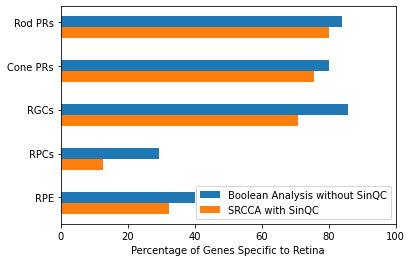

In [199]:
fig, ax = plt.subplots()
types = np.array(["Rod PRs", "Cone PRs", "RGCs", "RPCs", "RPE"])
ypos = np.arange(len(types))
boolean = np.array([83.87, 80.0, 85.71, 29.41, 40.0]) 
corr = np.array([80.0, 75.5, 70.96, 12.62, 32.41])
total_boolean = np.array([31,10,7,17,20])
total_corr = np.array([50,94,31,103,108])

ax.barh(ypos, boolean, 0.25)
ax.barh(ypos+0.25, corr, 0.25)
ax.set_yticks(ypos)
ax.set_yticklabels(types)
ax.set_xlabel('Percentage of Genes Specific to Retina')
ax.set_xlim(0,100)
ax.invert_yaxis()
ax.legend(labels=["Boolean Analysis without SinQC","SRCCA with SinQC"])

plt.show()

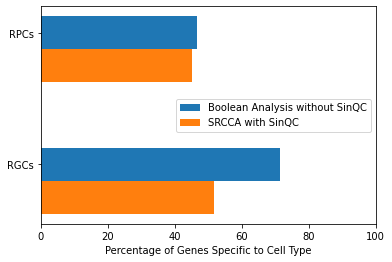

In [200]:
fig, ax = plt.subplots()
types = np.array(["RPCs", "RGCs"])
ypos = np.arange(len(types))
boolean = np.array([46.67, 71.43]) 
corr = np.array([45.0, 51.72])
total_boolean = np.array([7,17])
total_corr = np.array([31,103])

ax.barh(ypos, boolean, 0.25)
ax.barh(ypos+0.25, corr, 0.25)
ax.set_yticks(ypos)
ax.set_yticklabels(types)
ax.set_xlabel('Percentage of Genes Specific to Cell Type')
ax.set_xlim(0,100)
ax.invert_yaxis()
ax.legend(labels=["Boolean Analysis without SinQC","SRCCA with SinQC"])

plt.show()

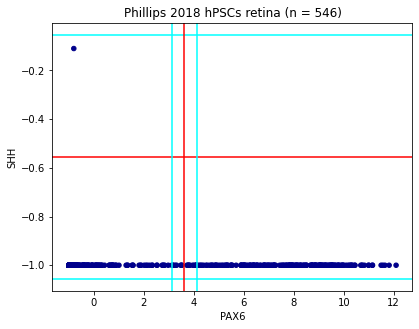

In [18]:
obj = hu.getHegemonPlots("RT29", "PAX6", "SHH")
hu.plotBooleanPair(obj[0])

In [227]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "B5"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

atype = h.getSurvName("c cell type")
hu.uniq(atype)

[8,
 'c cell type',
 'Unknown',
 'Glial Cell 3',
 'Cone 3',
 'Bipolar Cell 1',
 'Horizontal Cell',
 'Endothelial Cell',
 'Pericyte',
 'Glial Cell 5',
 'Bipolar Cell 2',
 'Rod 1',
 'Retinal Ganglion Cell',
 'Rod 2',
 'Glial Cell 4',
 'Amacrine Cell',
 'Microglia',
 'Glial Cell 2',
 'Glial Cell 1',
 'Cone 4']

In [68]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT29"

Arr3_phillips = getAllCorrs2(db, dbid, "ARR3", "c cell source", "All")
Arr3_phillips = sortCorr(Arr3_phillips)
Arr3_phillips_200 = np.array([i[0] for i in Arr3_phillips[1:200]])
Gnat2_phillips = getAllCorrs2(db, dbid, "GNAT2", "c cell source", "All")
Gnat2_phillips = sortCorr(Gnat2_phillips)
Gnat2_phillips_200 = np.array([i[0] for i in Gnat2_phillips[1:200]])

Arr3_Gnat2_phillips = set(Arr3_phillips_200).intersection(Gnat2_phillips_200)

In [70]:
print(sorted(Arr3_Gnat2_phillips))

['ANKH', 'ANKRD33B', 'AP1S3', 'ASMT', 'ATP1B2', 'C12orf5', 'C8orf84', 'C9orf3', 'CACNB2', 'CC2D2A', 'CCDC141', 'CDHR1', 'CHRNA5', 'CLMN', 'CNGB3', 'COX6B2', 'CPLX4', 'CRX', 'CYP1A2', 'DUSP19', 'EPHA10', 'EYS', 'FBXL20', 'FGF12', 'FMN1', 'FRMPD1', 'FSTL5', 'GNB3', 'GNGT2', 'GPC5', 'GPR155', 'GRM6', 'HCN1', 'HEG1', 'IBA57', 'IFT88', 'IMPG2', 'ITGA4', 'KCNV2', 'LMLN', 'MAK', 'MCF2', 'MPL', 'MPP4', 'MREG', 'MYO3B', 'NDNF', 'NIPAL3', 'ORAI2', 'PARD6B', 'PBLD', 'PDE6H', 'PEX5L', 'PNPO', 'PRICKLE2', 'RABL3', 'RABL5', 'RAX2', 'RCVRN', 'RD3', 'RP1', 'RPGRIP1', 'SFXN3', 'SH3GL2', 'SLC14A1', 'SLC14A2', 'SLC1A7', 'SLC24A2', 'SLC24A4', 'STXBP5L', 'TMEM120B', 'TMEM192', 'TRIM59', 'USH2A', 'WWC1', 'ZBTB43', 'ZNF716']


In [71]:
Crx_phillips = getAllCorrs2(db, dbid, "CRX", "c cell source", "All")
Crx_phillips = sortCorr(Crx_phillips)
Crx_phillips_200 = np.array([i[0] for i in Crx_phillips[1:200]])

Gnb3_phillips = getAllCorrs2(db, dbid, "GNB3", "c cell source", "All")
Gnb3_phillips = sortCorr(Gnb3_phillips)
Gnb3_phillips_200 = np.array([i[0] for i in Gnb3_phillips[1:200]])

Crx_Gnb3_Gnat2_phillips = set(Crx_phillips_200).intersection(Gnat2_phillips_200).intersection(Gnb3_phillips_200)

In [72]:
print(sorted(Crx_Gnb3_Gnat2_phillips))

['ANKRD33B', 'AP1S3', 'ATP1B2', 'CACNB2', 'CDHR1', 'CPLX4', 'CYP1A2', 'DUSP19', 'EPHA10', 'EYS', 'FSTL5', 'GPR155', 'GRM6', 'HCN1', 'IBA57', 'IMPG2', 'KCNV2', 'MAK', 'MPL', 'MPP4', 'MREG', 'ORAI2', 'PARD6B', 'PNPO', 'RAX2', 'RCVRN', 'RD3', 'RP1', 'RPGRIP1', 'SLC14A2', 'SLC24A2', 'SLC24A4', 'TMEM120B', 'USH2A', 'ZNF716']


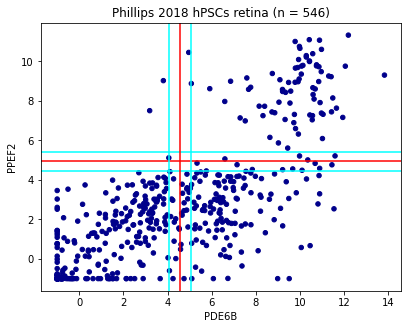

In [65]:
obj = hu.getHegemonPlots("RT29", "PDE6B", "PPEF2")
hu.plotBooleanPair(obj[0])

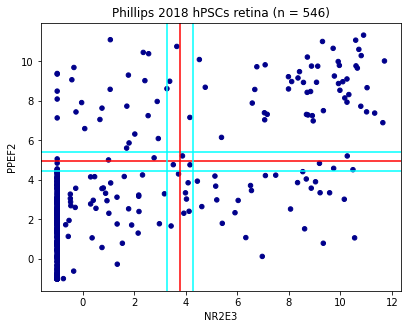

In [23]:
obj = hu.getHegemonPlots("RT29", "NR2E3", "PPEF2")
hu.plotBooleanPair(obj[0])

Daum

In [82]:
arr3 = "Group n mean sd 95% CI info A 3 4.97 1.44 1.39 8.55 info B 3 6.2 2.62 -0.31 12.7 info C 3 6.8 1.75 2.45 11.1 info D 3 5.29 1.16 2.41 8.17 info E 3 6.47 2.13 1.18 11.7 info F 3 8.09 0.702 6.35 9.84 info G 3 9.49 0.776 7.56 11.4 info H 3 9.22 0.288 8.51 9.94 info I 3 9.66 0.511 8.39 10.9 info J 3 9.48 0.492 8.26 10.7 info K 3 9.86 0.363 8.96 10.8 info L 3 9.81 0.776 7.88 11.7 info mature 1 12.3 0 12.3 12.3"
gnat2 = "Group n mean sd 95% CI info A 3 8.78 0.342 7.93 9.63 info B 3 9.11 0.544 7.76 10.5 info C 3 9.15 0.524 7.85 10.5 info D 3 8.5 0.439 7.41 9.59 info E 3 9.02 0.609 7.5 10.5 info F 3 9.44 0.0934 9.21 9.67 info G 3 10 0.739 8.19 11.9 info H 3 9.76 0.139 9.41 10.1 info I 3 10.1 0.405 9.11 11.1 info J 3 9.9 0.444 8.8 11 info K 3 10.3 0.438 9.24 11.4 info L 3 9.91 0.706 8.15 11.7 info mature 1 12 0 12 12"
wwc1 = "Group n mean sd 95% CI info A 3 3.7 0.316 2.92 4.48 info B 3 3.4 0.172 2.97 3.82 info C 3 3.61 0.178 3.17 4.06 info D 3 3.41 0.324 2.61 4.22 info E 3 3.66 0.353 2.78 4.53 info F 3 3.76 0.176 3.32 4.2 info G 3 4.16 0.41 3.14 5.18 info H 3 3.83 0.0625 3.67 3.98 info I 3 4.03 0.303 3.28 4.78 info J 3 4.14 0.446 3.04 5.25 info K 3 4.25 0.0425 4.15 4.36 info L 3 3.75 0.321 2.95 4.55 info mature 1 3.64 0 3.64 3.64"
arr3 = arr3.replace(" info ", "\n")
gnat2 = gnat2.replace(" info ", "\n")
wwc1 = wwc1.replace(" info ", "\n")
arr3 = arr3.replace(" ", ",")
gnat2 = gnat2.replace(" ", ",")
wwc1 = wwc1.replace(" ", ",")

In [86]:
print(wwc1)

Group,n,mean,sd,95%,CI
A,3,3.7,0.316,2.92,4.48
B,3,3.4,0.172,2.97,3.82
C,3,3.61,0.178,3.17,4.06
D,3,3.41,0.324,2.61,4.22
E,3,3.66,0.353,2.78,4.53
F,3,3.76,0.176,3.32,4.2
G,3,4.16,0.41,3.14,5.18
H,3,3.83,0.0625,3.67,3.98
I,3,4.03,0.303,3.28,4.78
J,3,4.14,0.446,3.04,5.25
K,3,4.25,0.0425,4.15,4.36
L,3,3.75,0.321,2.95,4.55
mature,1,3.64,0,3.64,3.64


### Table S2

In [35]:
# Rods
cellmarker = "PDE6A RHO GNAT1 CNGA1 GNGT1 NR2E3 NRL PPEF2 SAG"
lit = "NRL NR2E3 CNGA1 RGS9 CNGB1 RHO GNAT1 ROM1 GNGT1 GRK1 SAG PDE6B PDE6G"
boolean = "ABCA4 AIPL1 CASZ1 CNGA1 CNGB1 DEFB119 GNAT1 GNGT1 NR2E3 NRL PDE6B PDE6G PODXL PPEF2 RBP3 RGS9 RHO ROM1 SAG TTC39C"
res = set(cellmarker.split(" ")+lit.split(" ")).intersection(boolean.split(" "))
print(" ".join(res))

CNGA1 CNGB1 RGS9 GNGT1 PDE6G NR2E3 PDE6B SAG NRL ROM1 PPEF2 GNAT1 RHO


In [36]:
# Cones
cellmarker = "ARR3 GNAT2 OPN1SW PDE5H ARR3 GNGT2 GUCA1A GUCA1B GUCA1C OPN1LW OPN1MW PDE6C PDE6H"
lit = "ARR3 GNAT2 GNB3 GNGT2 PDE6H CRX PRDM1 RXRG THRB"
boolean = "ANKRD33B ARR3 C8orf46 CERKL EGFLAM FGF12 FMN1 GNAT2 GNGT2 MAOA PEX5L RD3 RS1 RXRG SEMA3C SH3GL2 SLC1A7 STXBP5L XRCC4"
res = set(cellmarker.split(" ")+lit.split(" ")).intersection(boolean.split(" "))
print(" ".join(res))

GNAT2 ARR3 RXRG GNGT2


In [37]:
# RGC
cellmarker = "ALCAM CNTN2 EBF1 EBF3 GAP43 NEFM NRN1 POU4F2 SNCG"
lit = "POU4F1 POU4F2 ISL1 RBPMS SNCG"
boolean = "EBF1 ELAVL2 ELAVL4 ISL1 POU4F2 SNCG"
res = set(cellmarker.split(" ")+lit.split(" ")).intersection(boolean.split(" "))
print(" ".join(res))

POU4F2 ISL1 EBF1 SNCG


In [38]:
# RPE
cellmarker = "VEGFA TIMP3 TTR TYR TYRP1 SERPINF1 RPE65 RBP1 RGR RLBP1 PLTP PMEL HNRNPH1 ENPP2 CRABP1 CRYAB CST3 CSTV BEST1"
lit = "ALDH1A3 RLBP1 RPE65 SLC6A20 RGR BEST1 TYRP1 TTLL4 PMEL"
boolean = "AK1 B4GALT1 BMS1 CCPG1 DIXDC1 DNTTIP2 ELOVL7 ETNK1 FOSB FRG1 GOLGA4 NSFL1C PSMC2 RBM23 RPE65 SCAF11 SDSL SEC22B SMC5 SPATS2L TMEM230 YIPF3"
res = set(cellmarker.split(" ")+lit.split(" ")).intersection(boolean.split(" "))
print(" ".join(res))

RPE65


In [39]:
# RPE Liu signature
sig = "RPE65 ABCA4 CA14 PLD5 TTLL4 SLC6A20 LRAT SLC45A2 SLC2A12 STRIP2 SLC4A2 TYRP1 TRPM3 RGR BEST1 TYR MFRP RDH5 DCT OTX2 RLBP1 BCMO1 RAX CRX SLC16A8"
boolean = "AK1 B4GALT1 BMS1 CCPG1 DIXDC1 DNTTIP2 ELOVL7 ETNK1 FOSB FRG1 GOLGA4 NSFL1C PSMC2 RBM23 RPE65 SCAF11 SDSL SEC22B SMC5 SPATS2L TMEM230 YIPF3"
res = set(sig.split(" ")).intersection(boolean.split(" "))
print(" ".join(res))

RPE65


In [40]:
# RPE Strunnikova signature
sig = "ADAM9 ADCY9 AHR ALDH1A3 ANKRD12 APLP1 ARL6IP1 ARMC9 ASAH1 ATF1 BAT2D1 BCLAF1 BDH2 BEST1 BHLHB3 BMP4 C1orf108 C20orf19 CALU CDH1 CDH3 CDO1 CHRNA3  CLCN4 COL8A2 COX15 CRIM1 CRX CSPG5 CTBP2 CYP20A1 DAP3 DCT DCUN1D4 DEGS1 DHPS DIXDC1 DMXL1 DNAJB14DUSP4 DZIP1 EFEMP1   EFHC1 EID1 ENPP2 FADS1 FAM18B FGFR2 FOXD1 FRZB GAS1 GEM GJA1 GOLPH3L GPM6B GPNMB GPR143 GRAMD3 GULP1 HSP90B1 IFT74 IGF2BP2 ITGAV ITM2B KLHL21 KLHL24 LAMP2 LAPTM4B LGALS8 LHX2 LIMCH1 LIN7C LOXL1 LSR MAB21L1 MANEA MAP9 MBNL2 MED8 MET MFAP3L MPDZ MPHOSPH9 MPHOSPH9 MYRIP NAV3 NDC80 NEDD4L NOL8 NRIP1 NUDT4 OSTM1 PAK1IP1 PCYOX1 PDPN PDZD8 PHACTR2 PITPNA PKNOX2 PLAG1 PLCB4 PLOD2 PRNP PSME4 PTGDS PTPRG RAB38 BM34 RBP1 RDH11 RHOBTB3 RNF13 RPE65 RRAGD SAS10 SCAMP1 SDC2 SEMA3C SERPINF1 SFRP5 SGK3 SIL1 SILV SIX3 SLC16A1 SLC16A1 SLC16A1 SLC16A4 SLC24A1 SLC39A6 SLC4A2 SLC6A15 SLC6A20 SMAD6 SMC3 SORBS2 SOSTDC1 SPAST STAM2 STCH SULF1 SULF1 TAX1BP1 TFPI2 TIMP3 TRPM1 TTLL4 TTR TYRP1 UBL3 USP34 VDP VEGFA WASL WWC2 WWTR1 ZNF19"
boolean = "AK1 B4GALT1 BMS1 CCPG1 DIXDC1 DNTTIP2 ELOVL7 ETNK1 FOSB FRG1 GOLGA4 NSFL1C PSMC2 RBM23 RPE65 SCAF11 SDSL SEC22B SMC5 SPATS2L TMEM230 YIPF3"
res = set(sig.split(" ")).intersection(boolean.split(" "))
print(" ".join(res))

RPE65 DIXDC1


In [41]:
# RPE Liao signature
sig = "PAX6 MITF OTX2 PEDF BEST1 ZO1 RPE65 RGR LRAT CRALBP"
boolean = "AK1 B4GALT1 BMS1 CCPG1 DIXDC1 DNTTIP2 ELOVL7 ETNK1 FOSB FRG1 GOLGA4 NSFL1C PSMC2 RBM23 RPE65 SCAF11 SDSL SEC22B SMC5 SPATS2L TMEM230 YIPF3"
res = set(sig.split(" ")).intersection(boolean.split(" "))
print(" ".join(res))

RPE65
